### segmentation label이 왜곡돼서 나타나는 이유

=> labeling의 문제가 아니었음

=> 전처리의 resampling 과정에서 label 이미지의 Resolution이 떨어지는 듯함

=> 추측 1. 300x300x300으로 바꾼 파일의 문제<br>
==> 처음부터 데이터 z길이를 다 저장한 배열을 만들어서 이미지 별로 resampling을 다르게 해야 할 것 같음

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0,1"

In [2]:
import numpy as np
import nibabel as nib
import pandas as pd
import random
import torch
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchio as tio
from models.segmentation import *
from models.sfcn import *
from models.pretrained_cnn import *
from models.vnet_regressor import *
from models.sfcn_fds import *
from models.pretrained_cnn_fds import *
from models.lds_utils import get_lds_kernel_window
from models.loss import weighted_focal_mse_loss, weighted_focal_l1_loss
from collections import Counter
from scipy.ndimage import zoom, convolve1d
from scipy.stats import pearsonr, spearmanr
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import gc
import wandb

In [3]:
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Sat Jun 17 17:45:54 2023
TorchIO version: 0.18.83


In [4]:
RANDOM_SEED = 551

In [5]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#print('Device:', device)
#print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Count of using GPUs: 2


### 데이터로더

In [7]:
def prepare_dataset(image_dir='./input_nifti_crop/', label_dir='./seg_nifti_crop/'):
        # img_list = list(map(lambda path: img_dir + path, os.listdir(img_dir)))
    filenames = sorted(os.listdir(label_dir))[:30]  # image_dir랑 label_dir에 저장되어있는 파일명이 같음
#     print(filenames)

    subjects = []
    for filename in tqdm(filenames):
        subject = tio.Subject(
            img = tio.ScalarImage(image_dir + filename),
            label = tio.LabelMap(label_dir + filename))   # label => LabelMap!!!!!!!
        subjects.append(subject)
    dataset = tio.SubjectsDataset(subjects)
    return subjects, dataset

In [8]:
def run_training(net_seg):
    running_seg_loss = 0.0
    running_seg_score = 0.0

    for i, data in enumerate(tqdm(train_loader, 0)):
        inputs, labels = data['img']['data'], data['label']['data']

#         print('before')
#         plt.imshow(labels[0,0,:,:,labels.shape[4]//2])
#         plt.show()

        
#         print('labels:', labels[0,0,:,:,labels.shape[4]//2])
        
#         l1=(labels==1)
#         l0=(labels==0)
#         labels = torch.cat((l0,l1),1)
        
#         print('after')
#         plt.imshow(labels[0,0,:,:,labels.shape[4]//2])
#         plt.show()
#         plt.imshow(labels[0,1,:,:,labels.shape[4]//2])
#         plt.show()
#         break

        if torch.cuda.is_available:
            inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

        inputs, labels = Variable(inputs), Variable(labels)
#         if (i % effective_batchsize) == 0:
        optimizer_seg.zero_grad()
        
        net_seg.train()
        outputs_seg = net_seg(inputs)

        outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
#         ##
#         print('input:',outputs_seg.shape,'target:', labels.shape)
        loss_seg, score_seg = criterion_seg(outputs_seg, labels)

        loss_seg.backward()
        optimizer_seg.step()

        running_seg_loss += loss_seg.detach().cpu().item()
        running_seg_score += score_seg.detach().cpu().item()
        gc.collect()
        torch.cuda.empty_cache()
    
    avg_loss = running_seg_loss / len(train_loader)
    avg_score = running_seg_score / len(train_loader)
    
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    
    return avg_loss, avg_score, one_output_seg, one_output_img, one_output_lbl

In [9]:
def run_validation(net_seg):
    net_seg.eval()
  
    running_seg_loss = 0.0
    running_seg_score = 0.0
    
    total_output_seg=[]
    total_output_img=[]
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(valid_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    
            
#             l1=(labels==1)
#             l0=(labels==0)
#             labels = torch.cat((l0,l1),1)
            
            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)
            
            net_seg.eval()
            
            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())
            
            outputs_seg = net_seg(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())
            
            loss_seg, score_seg = criterion_seg(outputs_seg, labels)
            
            running_seg_loss += loss_seg.detach().cpu().item()
            running_seg_score += score_seg.detach().cpu().item()
            
    avg_loss = running_seg_loss / len(valid_loader)
    avg_score = running_seg_score / len(valid_loader)
    
    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    #total_output_img=np.reshape(1,224,224,32)
    #total_output_seg=np.reshape(1,224,224,32)

    return avg_loss, avg_score, one_output_seg, one_output_img, one_output_lbl, total_output_seg, total_output_img

In [10]:
image_dir = './input_nifti_300/'  #'./input_nifti/'
label_dir = './seg_nifti_300_2306/'  #'./input_nifti_seg/'
subjects, dataset = prepare_dataset(image_dir, label_dir)

100%|████████████████████████████████████████| 30/30 [00:00<00:00, 11962.08it/s]


In [11]:
print('Dataset size : ', len(dataset), 'subjects')

Dataset size :  30 subjects


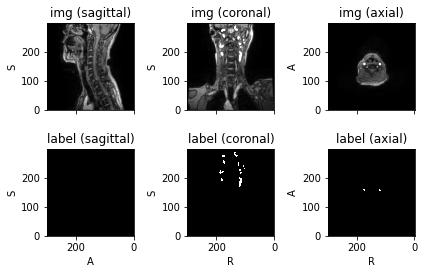

In [12]:
## 데이터셋 확인
for training_instance in dataset:
    training_instance.plot()  # SubjectDataset
    break

In [13]:
set_seed()

split_rate = 0.8
_, _, _, d = dataset[0].shape
w, h = 300, 300
img_size = 192  # [16,32,48,64,80,96,112,128,144,160, 176,192,208,224]
sample_rate = 300 / img_size

# transformation
train_transform = tio.Compose([
    tio.Resample(sample_rate),
#     tio.Resample(1.5),
#     tio.Crop((44,44,44,44,54,34)),
#     tio.Clamp(480,720),
    tio.ZNormalization(),
#     tio.OneHot(),
])

# data set
dataset = tio.SubjectsDataset(
    subjects, transform=train_transform)

In [14]:
# ## 모델 확인
# normalization = 'groupnorm'
# net_seg = VNet(n_channels=1, n_classes=2, n_filters=16, normalization=normalization)
# net_seg

### segmentation 학습 (n=30)

In [15]:
blocknum = 1
normalization = 'groupnorm'
num_epochs = 50
lr = 0.001
optim_class = optim.Adam
batch_size = 6

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.50s/it]


# EPOCH 1 / 50
Train


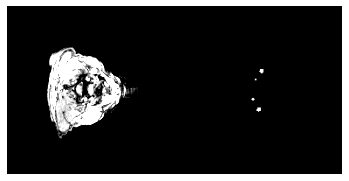

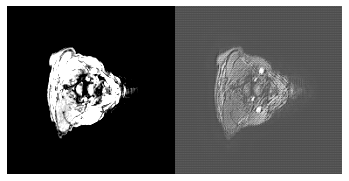

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.68s/it]


# EPOCH 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.60s/it]


# EPOCH 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.78s/it]


# EPOCH 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.60s/it]


# EPOCH 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.63s/it]


# EPOCH 6 / 50
Train


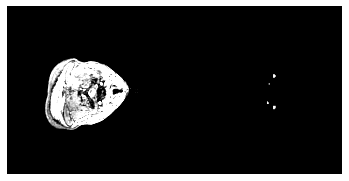

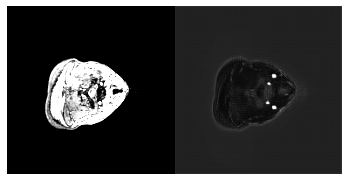

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.62s/it]


# EPOCH 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.74s/it]


# EPOCH 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.76s/it]


# EPOCH 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.77s/it]


# EPOCH 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.80s/it]


# EPOCH 11 / 50
Train


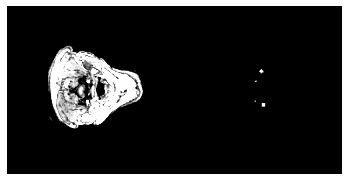

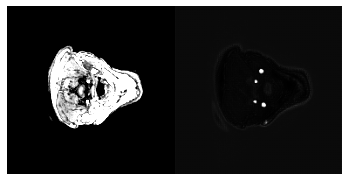

100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.88s/it]


# EPOCH 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.61s/it]


# EPOCH 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.64s/it]


# EPOCH 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.76s/it]


# EPOCH 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.61s/it]


# EPOCH 16 / 50
Train


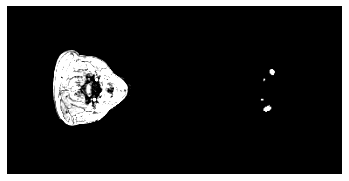

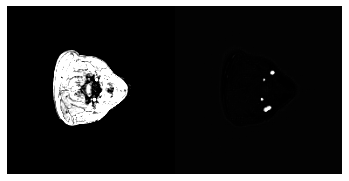

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.74s/it]


# EPOCH 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.73s/it]


# EPOCH 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.76s/it]


# EPOCH 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]


# EPOCH 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.75s/it]


# EPOCH 21 / 50
Train


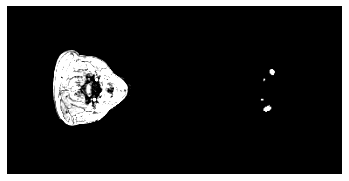

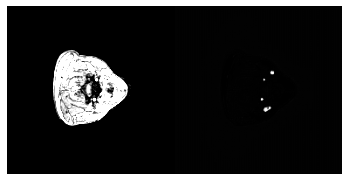

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.73s/it]


# EPOCH 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.76s/it]


# EPOCH 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.58s/it]


# EPOCH 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.62s/it]


# EPOCH 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.76s/it]


# EPOCH 26 / 50
Train


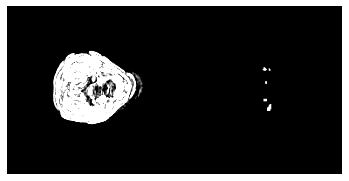

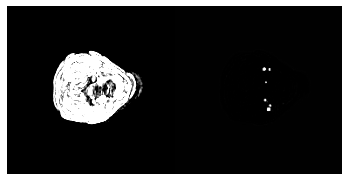

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.74s/it]


# EPOCH 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.75s/it]


# EPOCH 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.60s/it]


# EPOCH 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.77s/it]


# EPOCH 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]


# EPOCH 31 / 50
Train


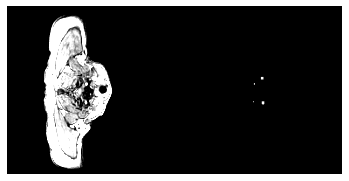

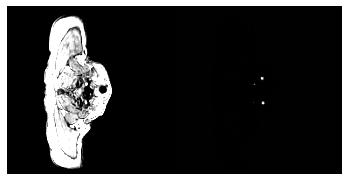

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.74s/it]


# EPOCH 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.75s/it]


# EPOCH 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.76s/it]


# EPOCH 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.74s/it]


# EPOCH 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.74s/it]


# EPOCH 36 / 50
Train


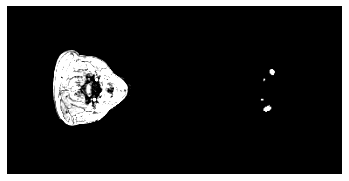

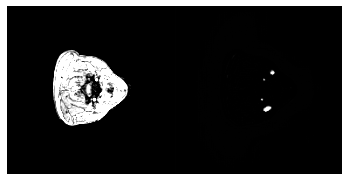

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.74s/it]


# EPOCH 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.73s/it]


# EPOCH 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.75s/it]


# EPOCH 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.73s/it]


# EPOCH 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.60s/it]


# EPOCH 41 / 50
Train


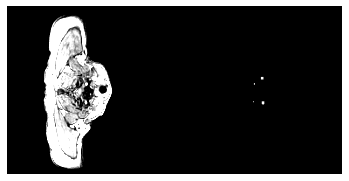

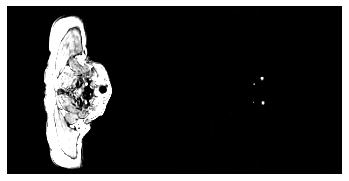

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.73s/it]


# EPOCH 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]


# EPOCH 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.77s/it]


# EPOCH 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.75s/it]


# EPOCH 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.77s/it]


# EPOCH 46 / 50
Train


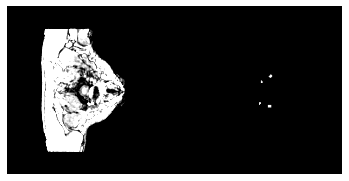

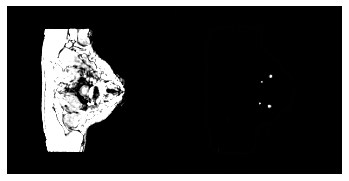

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.70s/it]


# EPOCH 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.60s/it]


# EPOCH 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.75s/it]


# EPOCH 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:27<00:00,  5.59s/it]


# EPOCH 50 / 50


train_loss,█████▇▇▇▅▄▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score,▁▁▁▁▁▂▂▂▄▅▅▆▇▇▇▇▇▇██████████████████████
train_loss,0.60041
train_score,0.39959


In [16]:
# 재실험: Segmentation weight 생성
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=True)

set_seed()
net_seg = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet-%d"%blocknum, "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__})
wandb.watch(net_seg)

train_losses = []
#     validation_losses = []

S = img_size // 2

#     min_valid_loss = 1.0
min_loss = 1.0

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

set_seed()
for epoch in range(num_epochs):
    train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
#         valid_loss, valid_score, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
#         validation_losses.append(valid_loss)

    train_img = wandb.Image(train_img_part[0,:,:,S])
    train_truth = wandb.Image(train_input_lbl[0,:,:,S], caption="Ground truth")
    train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")
#         valid_img = wandb.Image(valid_input_img_part[0,:,:,S])
#         valid_truth = wandb.Image(valid_input_lbl_part[1,:,:,S], caption="Ground truth")
#         valid_pred = wandb.Image(valid_output_seg_part[1,:,:,S], caption="Prediction")

#         if min_valid_loss > valid_loss:
#             min_valid_loss = valid_loss
#             torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        
    if min_loss > train_loss:
        min_loss = train_loss
        torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        

    lbl_train = train_input_lbl[0, :, : ,S]
    seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]


    if epoch%5==0:
        print('Train')
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.axis("off")
        plt.show()

#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.axis("off")
        plt.show()

#             print('Valid')
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.show()  
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.show()

#             # loss curve
#             plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
#             red_patch = mpatches.Patch(color='red', label='Validation')
#             blue_patch = mpatches.Patch(color='blue', label='Training')
#             plt.legend(handles=[red_patch, blue_patch])
#             plt.show()


    wandb.log({"train_loss": train_loss, "train_score": train_score,
               "train_img": train_img, "train_label": train_truth, "train_pred": train_pred,})
wandb.finish()

In [17]:
blocknum = 2
normalization = 'groupnorm'
num_epochs = 50
lr = 0.001
optim_class = optim.Adam
batch_size = 6

100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.85s/it]


# EPOCH 1 / 50
Train


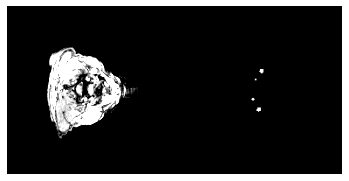

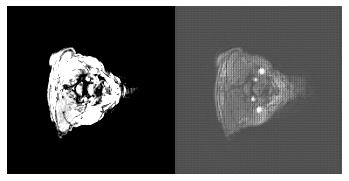

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.37s/it]


# EPOCH 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.98s/it]


# EPOCH 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.93s/it]


# EPOCH 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.26s/it]


# EPOCH 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.94s/it]


# EPOCH 6 / 50
Train


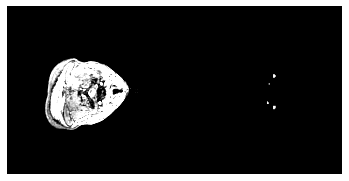

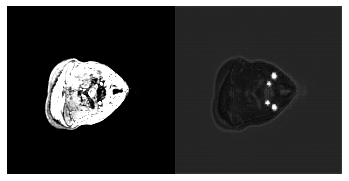

100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.93s/it]


# EPOCH 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.94s/it]


# EPOCH 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.90s/it]


# EPOCH 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.82s/it]


# EPOCH 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.18s/it]


# EPOCH 11 / 50
Train


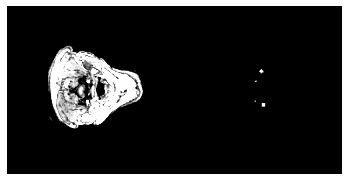

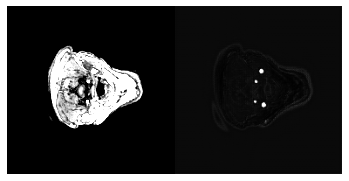

100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.97s/it]


# EPOCH 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.96s/it]


# EPOCH 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.77s/it]


# EPOCH 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.93s/it]


# EPOCH 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.78s/it]


# EPOCH 16 / 50
Train


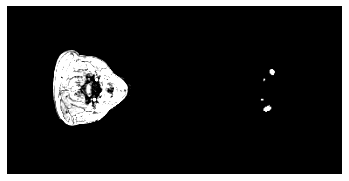

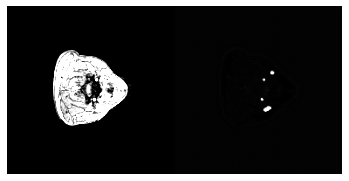

100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.91s/it]


# EPOCH 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.78s/it]


# EPOCH 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.77s/it]


# EPOCH 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.96s/it]


# EPOCH 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.95s/it]


# EPOCH 21 / 50
Train


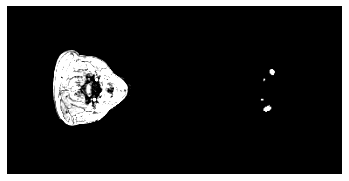

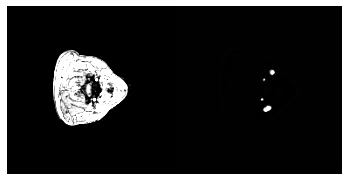

100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.96s/it]


# EPOCH 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.03s/it]


# EPOCH 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.99s/it]


# EPOCH 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.95s/it]


# EPOCH 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.10s/it]


# EPOCH 26 / 50
Train


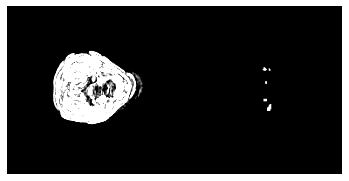

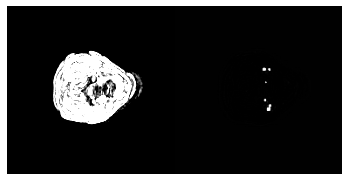

100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.88s/it]


# EPOCH 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.97s/it]


# EPOCH 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.05s/it]


# EPOCH 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.85s/it]


# EPOCH 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.05s/it]


# EPOCH 31 / 50
Train


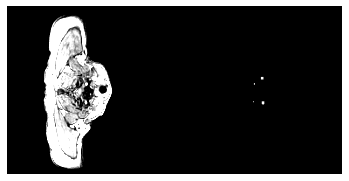

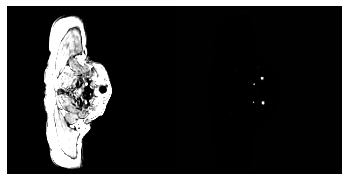

100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.80s/it]


# EPOCH 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.92s/it]


# EPOCH 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.92s/it]


# EPOCH 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.81s/it]


# EPOCH 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.93s/it]


# EPOCH 36 / 50
Train


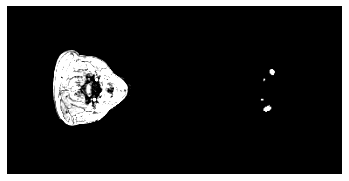

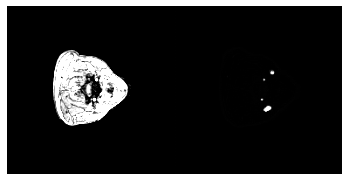

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.77s/it]


# EPOCH 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.80s/it]


# EPOCH 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.93s/it]


# EPOCH 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.79s/it]


# EPOCH 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.78s/it]


# EPOCH 41 / 50
Train


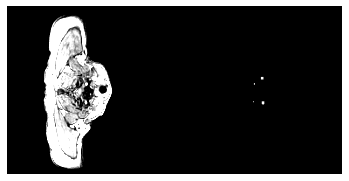

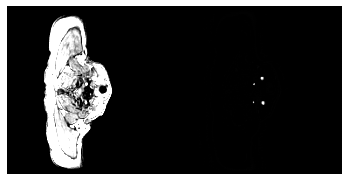

100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.88s/it]


# EPOCH 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.82s/it]


# EPOCH 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.78s/it]


# EPOCH 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.95s/it]


# EPOCH 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.06s/it]


# EPOCH 46 / 50
Train


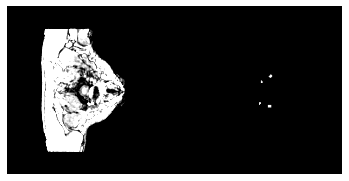

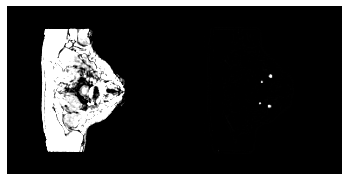

100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.80s/it]


# EPOCH 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.78s/it]


# EPOCH 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.05s/it]


# EPOCH 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:29<00:00,  5.99s/it]


# EPOCH 50 / 50


train_loss,█████▇▇▇▅▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score,▁▁▁▁▁▂▂▂▄▄▅▆▇▇▇▇▇▇██████████████████████
train_loss,0.5777
train_score,0.4223


In [18]:
# 재실험: Segmentation weight 생성
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=True)

set_seed()
net_seg = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet-%d"%blocknum, "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__})
wandb.watch(net_seg)

train_losses = []
#     validation_losses = []

S = img_size // 2

#     min_valid_loss = 1.0
min_loss = 1.0

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

set_seed()
for epoch in range(num_epochs):
    train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
#         valid_loss, valid_score, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
#         validation_losses.append(valid_loss)

    train_img = wandb.Image(train_img_part[0,:,:,S])
    train_truth = wandb.Image(train_input_lbl[0,:,:,S], caption="Ground truth")
    train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")
#         valid_img = wandb.Image(valid_input_img_part[0,:,:,S])
#         valid_truth = wandb.Image(valid_input_lbl_part[1,:,:,S], caption="Ground truth")
#         valid_pred = wandb.Image(valid_output_seg_part[1,:,:,S], caption="Prediction")

#         if min_valid_loss > valid_loss:
#             min_valid_loss = valid_loss
#             torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        
    if min_loss > train_loss:
        min_loss = train_loss
        torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        

    lbl_train = train_input_lbl[0, :, : ,S]
    seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]


    if epoch%5==0:
        print('Train')
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.axis("off")
        plt.show()

#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.axis("off")
        plt.show()

#             print('Valid')
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.show()  
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.show()

#             # loss curve
#             plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
#             red_patch = mpatches.Patch(color='red', label='Validation')
#             blue_patch = mpatches.Patch(color='blue', label='Training')
#             plt.legend(handles=[red_patch, blue_patch])
#             plt.show()


    wandb.log({"train_loss": train_loss, "train_score": train_score,
               "train_img": train_img, "train_label": train_truth, "train_pred": train_pred,})
wandb.finish()

In [19]:
blocknum = 3
normalization = 'groupnorm'
num_epochs = 50
lr = 0.001
optim_class = optim.Adam
batch_size = 6

100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.56s/it]


# EPOCH 1 / 50
Train


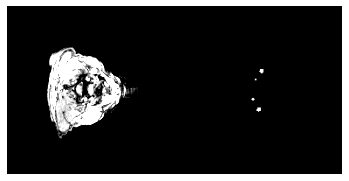

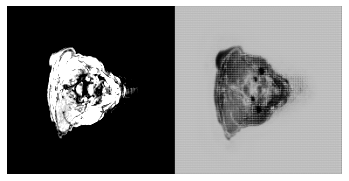

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.21s/it]


# EPOCH 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.33s/it]


# EPOCH 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.24s/it]


# EPOCH 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.28s/it]


# EPOCH 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.27s/it]


# EPOCH 6 / 50
Train


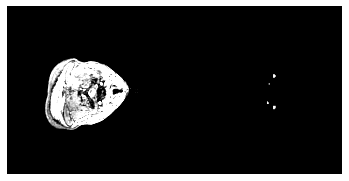

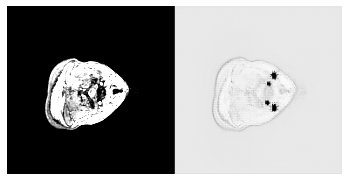

100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.20s/it]


# EPOCH 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.26s/it]


# EPOCH 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.30s/it]


# EPOCH 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.38s/it]


# EPOCH 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.26s/it]


# EPOCH 11 / 50
Train


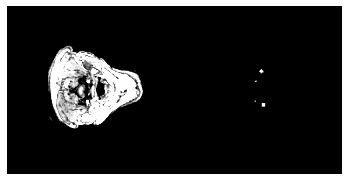

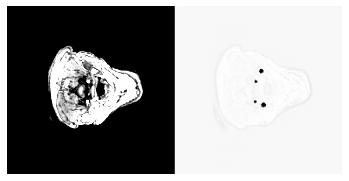

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.25s/it]


# EPOCH 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.27s/it]


# EPOCH 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.21s/it]


# EPOCH 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.34s/it]


# EPOCH 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.09s/it]


# EPOCH 16 / 50
Train


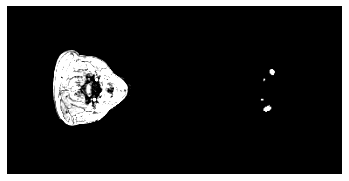

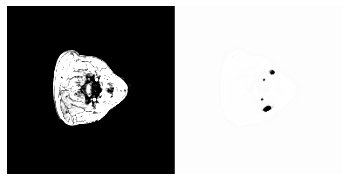

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.34s/it]


# EPOCH 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.25s/it]


# EPOCH 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.18s/it]


# EPOCH 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.22s/it]


# EPOCH 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


# EPOCH 21 / 50
Train


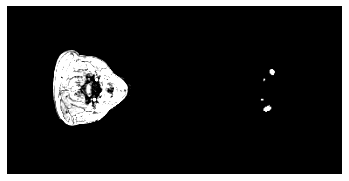

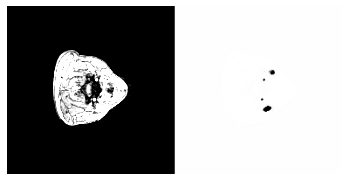

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.36s/it]


# EPOCH 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.42s/it]


# EPOCH 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.27s/it]


# EPOCH 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.24s/it]


# EPOCH 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.36s/it]


# EPOCH 26 / 50
Train


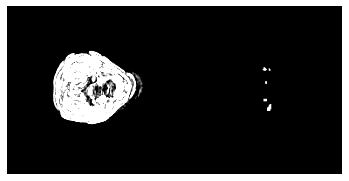

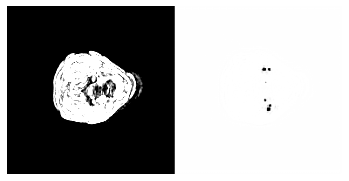

100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.46s/it]


# EPOCH 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.40s/it]


# EPOCH 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.41s/it]


# EPOCH 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


# EPOCH 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.18s/it]


# EPOCH 31 / 50
Train


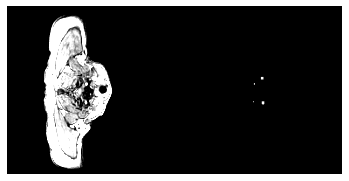

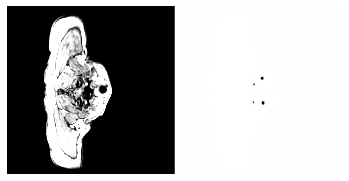

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.37s/it]


# EPOCH 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.24s/it]


# EPOCH 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.22s/it]


# EPOCH 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.28s/it]


# EPOCH 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.24s/it]


# EPOCH 36 / 50
Train


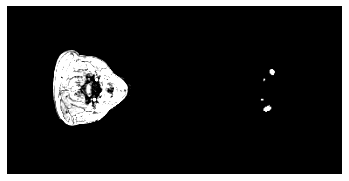

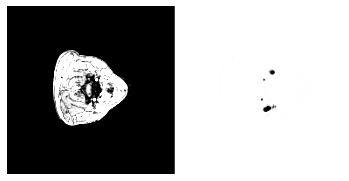

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.29s/it]


# EPOCH 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.26s/it]


# EPOCH 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.34s/it]


# EPOCH 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.35s/it]


# EPOCH 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.35s/it]


# EPOCH 41 / 50
Train


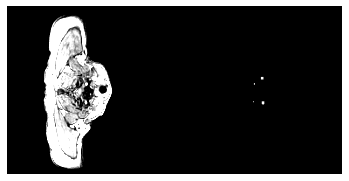

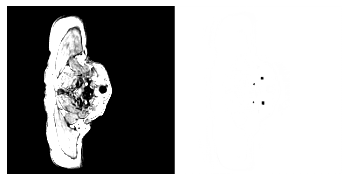

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.36s/it]


# EPOCH 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.28s/it]


# EPOCH 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.13s/it]


# EPOCH 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.28s/it]


# EPOCH 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.32s/it]


# EPOCH 46 / 50
Train


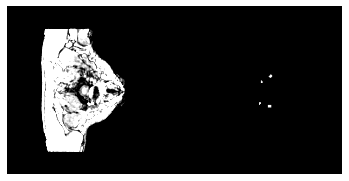

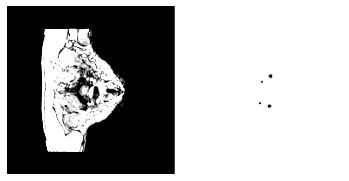

100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.19s/it]


# EPOCH 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


# EPOCH 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.26s/it]


# EPOCH 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.36s/it]


# EPOCH 50 / 50


train_loss,████▇▇▇▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score,▁▁▁▁▂▂▂▃▅▅▆▆▇▇▇▇▇▇██████████████████████
train_loss,0.56107
train_score,0.43893


In [20]:
# 재실험: Segmentation weight 생성
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=True)

set_seed()
net_seg = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet-%d"%blocknum, "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__})
wandb.watch(net_seg)

train_losses = []
#     validation_losses = []

S = img_size // 2

#     min_valid_loss = 1.0
min_loss = 1.0

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

set_seed()
for epoch in range(num_epochs):
    train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
#         valid_loss, valid_score, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
#         validation_losses.append(valid_loss)

    train_img = wandb.Image(train_img_part[0,:,:,S])
    train_truth = wandb.Image(train_input_lbl[0,:,:,S], caption="Ground truth")
    train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")
#         valid_img = wandb.Image(valid_input_img_part[0,:,:,S])
#         valid_truth = wandb.Image(valid_input_lbl_part[1,:,:,S], caption="Ground truth")
#         valid_pred = wandb.Image(valid_output_seg_part[1,:,:,S], caption="Prediction")

#         if min_valid_loss > valid_loss:
#             min_valid_loss = valid_loss
#             torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        
    if min_loss > train_loss:
        min_loss = train_loss
        torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        

    lbl_train = train_input_lbl[0, :, : ,S]
    seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]


    if epoch%5==0:
        print('Train')
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.axis("off")
        plt.show()

#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.axis("off")
        plt.show()

#             print('Valid')
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.show()  
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.show()

#             # loss curve
#             plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
#             red_patch = mpatches.Patch(color='red', label='Validation')
#             blue_patch = mpatches.Patch(color='blue', label='Training')
#             plt.legend(handles=[red_patch, blue_patch])
#             plt.show()


    wandb.log({"train_loss": train_loss, "train_score": train_score,
               "train_img": train_img, "train_label": train_truth, "train_pred": train_pred,})
wandb.finish()

In [21]:
blocknum = 4
normalization = 'groupnorm'
num_epochs = 50
lr = 0.001
optim_class = optim.Adam
batch_size = 6

100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.43s/it]


# EPOCH 1 / 50
Train


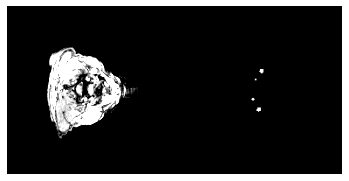

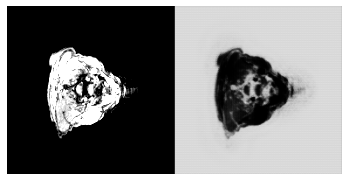

100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.45s/it]


# EPOCH 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.41s/it]


# EPOCH 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.40s/it]


# EPOCH 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.40s/it]


# EPOCH 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.57s/it]


# EPOCH 6 / 50
Train


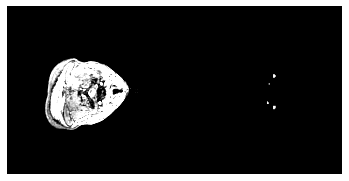

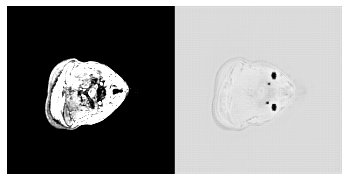

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.40s/it]


# EPOCH 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.34s/it]


# EPOCH 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.41s/it]


# EPOCH 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.25s/it]


# EPOCH 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.28s/it]


# EPOCH 11 / 50
Train


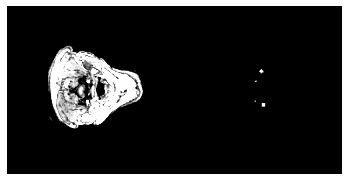

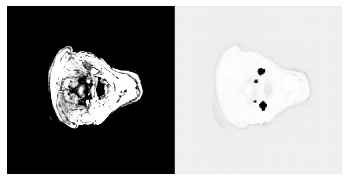

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.33s/it]


# EPOCH 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.41s/it]


# EPOCH 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.32s/it]


# EPOCH 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.47s/it]


# EPOCH 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.29s/it]


# EPOCH 16 / 50
Train


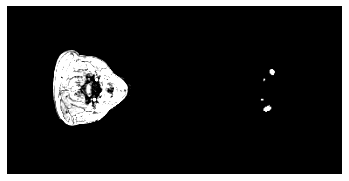

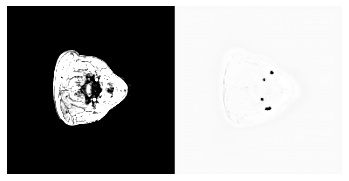

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.34s/it]


# EPOCH 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.24s/it]


# EPOCH 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.47s/it]


# EPOCH 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.40s/it]


# EPOCH 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.36s/it]


# EPOCH 21 / 50
Train


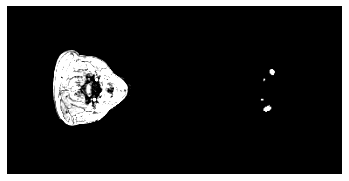

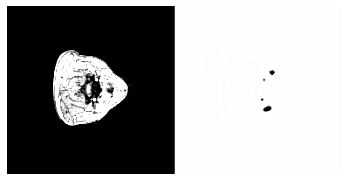

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.38s/it]


# EPOCH 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.40s/it]


# EPOCH 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.41s/it]


# EPOCH 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.38s/it]


# EPOCH 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.31s/it]


# EPOCH 26 / 50
Train


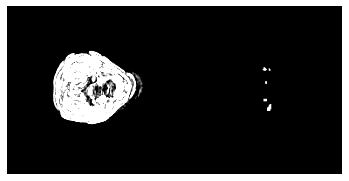

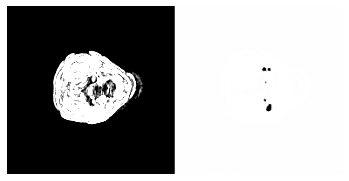

100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.50s/it]


# EPOCH 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.45s/it]


# EPOCH 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.53s/it]


# EPOCH 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.25s/it]


# EPOCH 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.39s/it]


# EPOCH 31 / 50
Train


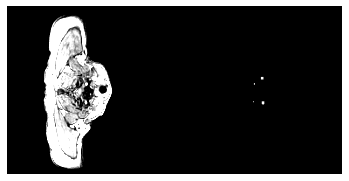

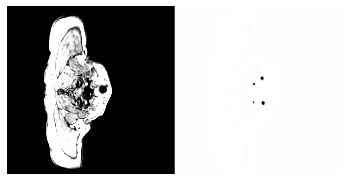

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.37s/it]


# EPOCH 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.41s/it]


# EPOCH 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.19s/it]


# EPOCH 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.31s/it]


# EPOCH 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.38s/it]


# EPOCH 36 / 50
Train


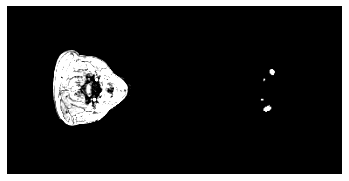

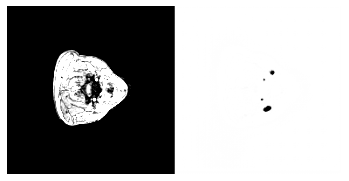

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.32s/it]


# EPOCH 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.39s/it]


# EPOCH 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


# EPOCH 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.24s/it]


# EPOCH 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:32<00:00,  6.40s/it]


# EPOCH 41 / 50
Train


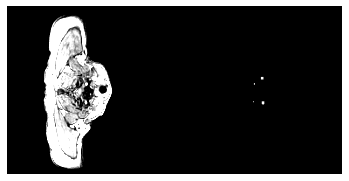

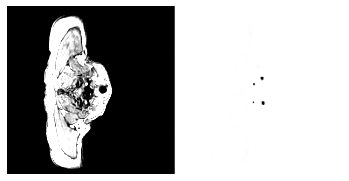

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.32s/it]


# EPOCH 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.37s/it]


# EPOCH 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


# EPOCH 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.39s/it]


# EPOCH 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.36s/it]


# EPOCH 46 / 50
Train


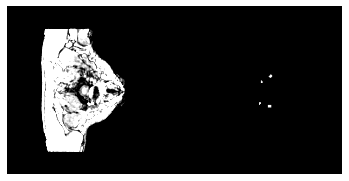

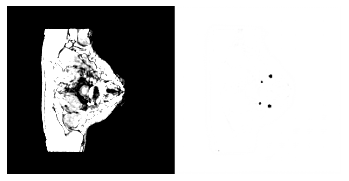

100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.40s/it]


# EPOCH 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.26s/it]


# EPOCH 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.36s/it]


# EPOCH 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:31<00:00,  6.23s/it]


# EPOCH 50 / 50


train_loss,██████▇▇▇▆▆▆▄▃▃▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_score,▁▁▁▁▁▁▂▂▂▃▃▃▅▆▆▇▇▇▇▇▇████▇██████████████
train_loss,0.57389
train_score,0.42611


In [22]:
# 재실험: Segmentation weight 생성
train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=True)

set_seed()
net_seg = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
net_seg = torch.nn.DataParallel(net_seg, device_ids=[0, 1])
net_seg.cuda()

wandb.init(
    project='202303-segmentation',
    config={"model": "VNet-%d"%blocknum, "input_size": img_size,
            "start_lr": lr, "epochs": num_epochs, "batch_size": batch_size,
            "cost_function": "DiceLoss", "optimizer": optim_class.__name__})
wandb.watch(net_seg)

train_losses = []
#     validation_losses = []

S = img_size // 2

#     min_valid_loss = 1.0
min_loss = 1.0

optimizer_seg = optim_class(net_seg.parameters(), lr=lr)
criterion_seg = DiceLoss()
# criterion_seg = GeneralizedDiceLoss()
# scheduler = optim.lr_scheduler.StepLR(optimizer_seg, step_size=20, gamma=0.1)

set_seed()
for epoch in range(num_epochs):
    train_loss, train_score, train_seg_part, train_img_part, train_input_lbl = run_training(net_seg)
#         valid_loss, valid_score, valid_output_seg_part, valid_input_img_part, valid_input_lbl_part, valid_total_seg, valid_total_img = run_validation(net_seg)
    print('# EPOCH %d / %d'%(epoch+1, num_epochs))
    train_losses.append(train_loss)
#         validation_losses.append(valid_loss)

    train_img = wandb.Image(train_img_part[0,:,:,S])
    train_truth = wandb.Image(train_input_lbl[0,:,:,S], caption="Ground truth")
    train_pred = wandb.Image(train_seg_part[1,:,:,S], caption="Prediction")
#         valid_img = wandb.Image(valid_input_img_part[0,:,:,S])
#         valid_truth = wandb.Image(valid_input_lbl_part[1,:,:,S], caption="Ground truth")
#         valid_pred = wandb.Image(valid_output_seg_part[1,:,:,S], caption="Prediction")

#         if min_valid_loss > valid_loss:
#             min_valid_loss = valid_loss
#             torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        
    if min_loss > train_loss:
        min_loss = train_loss
        torch.save(net_seg.state_dict(), 'pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size))        

    lbl_train = train_input_lbl[0, :, : ,S]
    seg_train = train_seg_part[0, :, : , S]
#     lbl_valid = valid_input_lbl_part[0, :, : , S]
#     seg_valid = valid_output_seg_part[0, :, : , S]


    if epoch%5==0:
        print('Train')
#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S],train_input_lbl[1, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_input_lbl[0, :, : ,S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
        plt.axis("off")
        plt.show()

#         plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[0, :, : , S],train_seg_part[1, :, : ,S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.imshow(np.squeeze(np.concatenate((1*train_img_part[0,:,:,S],train_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
        plt.axis("off")
        plt.show()

#             print('Valid')
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S],valid_input_lbl_part[1, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_input_lbl_part[0, :, : , S]),axis=1)),vmin=0,vmax=1, cmap='gray') # label
#             plt.show()  
#     #         plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S],valid_output_seg_part[1, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.imshow(np.squeeze(np.concatenate((1*valid_input_img_part[0,:,:,S],valid_output_seg_part[0, :, : , S]),axis=1)),vmin=0,vmax=1,cmap='gray') # label
#             plt.show()

#             # loss curve
#             plt.plot(range(len(train_losses)), train_losses, 'b', range(len(validation_losses)), validation_losses,'r')
#             red_patch = mpatches.Patch(color='red', label='Validation')
#             blue_patch = mpatches.Patch(color='blue', label='Training')
#             plt.legend(handles=[red_patch, blue_patch])
#             plt.show()


    wandb.log({"train_loss": train_loss, "train_score": train_score,
               "train_img": train_img, "train_label": train_truth, "train_pred": train_pred,})
wandb.finish()

---

### Segmentation 평가

In [ ]:
##################
y_pred_list = []
for iter, batch in enumerate(test_loader):
    X = batch['X']
    y_pred = model(X)
    y_pred_list.append(y_pred)
y_predicted = torch.cat([*y_pred_list], dim=0)
y_predicted = (y_predicted >= 0.5).float()  # threshold (round values)

In [41]:
# Evaluation

text = "-------------------------------------------------------------------------------\n"
text += "Model\tPA\tDSC\tPPV\tRecall\tSpecificity\t\n"
text += "===============================================================================\n"

for blocknum in range(1, 5):
    normalization = 'groupnorm'
    criterion = SegMetrics()
    
    net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size)))
    net.cuda()

    net.eval()

    running_pa = 0.0
    running_dice = 0.0
    running_prec = 0.0
    running_rec = 0.0
    running_spec = 0.0

    total_output_seg=[]
    total_output_img=[]

    with torch.no_grad():
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    

    #             l1=(labels==1)
    #             l0=(labels==0)
    #             labels = torch.cat((l0,l1),1)

            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()

            total_inputs=copy.deepcopy(inputs)
            total_output_img.append(total_inputs.detach().cpu().numpy())

            outputs_seg = net(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)
            total_outputs=copy.deepcopy(outputs_seg)
            total_output_seg.append(total_outputs.detach().cpu().numpy())
            
            outputs_seg = (outputs_seg >= 0.5).float()  # 확률값 => 0, 1로
            pixel_acc, dice, precision, recall, specificity = criterion(outputs_seg, labels)

            running_pa += pixel_acc.detach().cpu().item()
            running_dice += dice.detach().cpu().item()
            running_prec += precision.detach().cpu().item()
            running_rec += recall.detach().cpu().item()
            running_spec += specificity.detach().cpu().item()

    avg_pa = running_pa / len(train_loader)
    avg_dice = running_dice / len(train_loader)
    avg_prec = running_prec / len(train_loader)
    avg_rec = running_rec / len(train_loader)
    avg_spec = running_spec / len(train_loader)

    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    #total_output_img=np.reshape(1,224,224,32)
    #total_output_seg=np.reshape(1,224,224,32)
    
    text += "VNet-{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\n".format(blocknum, avg_pa, avg_dice, avg_prec, avg_rec, avg_spec)    
text += "===============================================================================\n"
print(text)

100%|█████████████████████████████████████████████| 5/5 [00:23<00:00,  4.78s/it]


-------------------------------------------------------------------------------
Model	PA	DSC	PPV	Recall	Specificity	
VNet-1	0.500	0.390	0.390	0.500	0.500
VNet-2	0.500	0.400	0.462	0.500	0.500
VNet-3	0.500	0.433	0.437	0.500	0.500
VNet-4	0.500	0.409	0.381	0.500	0.500



In [27]:
outputs_seg

tensor([[[[[1.7771e-03, 1.5009e-03, 1.8121e-03,  ..., 1.6478e-03,
            1.9019e-03, 1.7574e-03],
           [1.9639e-03, 2.5959e-03, 2.2915e-03,  ..., 2.6655e-03,
            2.1728e-03, 3.3076e-03],
           [1.9783e-03, 2.0848e-03, 1.8351e-03,  ..., 2.5243e-03,
            2.2834e-03, 1.9915e-03],
           ...,
           [1.3000e-03, 2.3228e-03, 1.8560e-03,  ..., 2.1188e-03,
            2.0169e-03, 3.0970e-03],
           [2.5235e-03, 2.2314e-03, 2.3809e-03,  ..., 2.8166e-03,
            2.5356e-03, 2.2368e-03],
           [1.2802e-03, 2.4784e-03, 8.1147e-04,  ..., 2.4865e-03,
            7.8003e-04, 2.4233e-03]],

          [[1.2516e-03, 1.6792e-03, 1.6940e-03,  ..., 2.2111e-03,
            1.7060e-03, 1.1546e-03],
           [3.1747e-03, 1.7342e-03, 2.3617e-03,  ..., 2.2296e-03,
            2.5505e-03, 1.5551e-03],
           [1.8137e-03, 2.1089e-03, 2.3525e-03,  ..., 2.8427e-03,
            3.4216e-03, 1.6113e-03],
           ...,
           [2.2486e-03, 1.7709e-03, 1.9

  0%|                                                     | 0/5 [00:22<?, ?it/s]


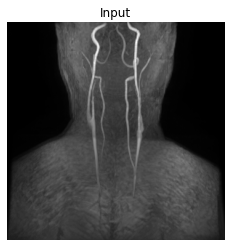

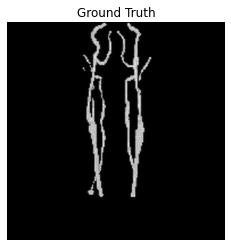

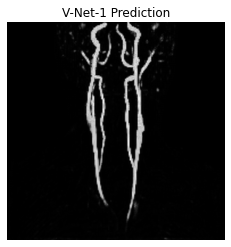

  0%|                                                     | 0/5 [00:22<?, ?it/s]


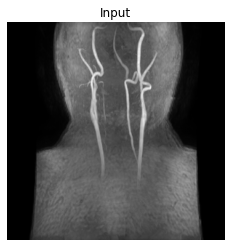

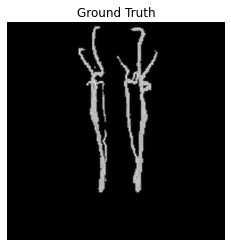

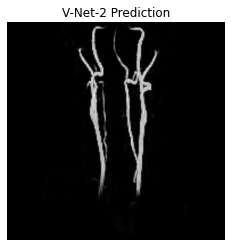

  0%|                                                     | 0/5 [00:22<?, ?it/s]


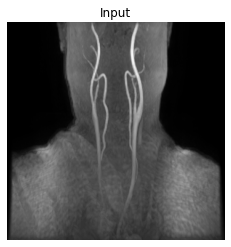

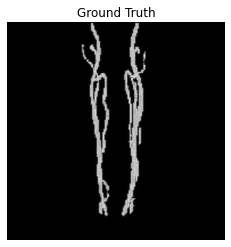

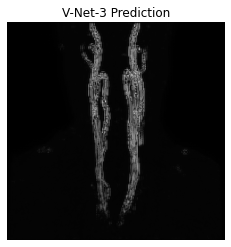

  0%|                                                     | 0/5 [00:22<?, ?it/s]


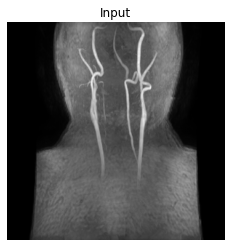

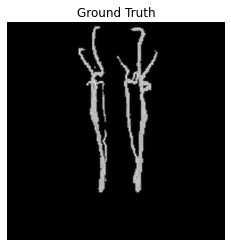

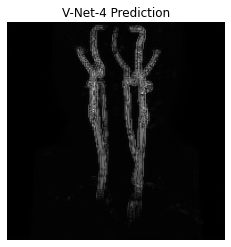

In [42]:
# Evaluation (예시 이미지): 새로 labeling 해서 학습한 모델
from scipy.ndimage import rotate, zoom

for blocknum in range(1, 5):
    normalization = 'groupnorm'

    net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2306_vnetencoder-{}_{}_best'.format(blocknum, img_size)))
    net.cuda()

    net.eval()

    with torch.no_grad():
        for i, data in enumerate(tqdm(train_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    

    #             l1=(labels==1)
    #             l0=(labels==0)
    #             labels = torch.cat((l0,l1),1)

            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()

            outputs_seg = net(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)            
            break

    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    scale = 300 / img_size

    plt.title("Input")
    img_in = zoom(one_output_img[0], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_in, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    plt.title("Ground Truth")
    img_gt = zoom(one_output_lbl[0], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_gt, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    plt.title("V-Net-{} Prediction".format(blocknum))
    img_p = zoom(one_output_seg[1], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_p, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    # nifti_img = nib.Nifti1Image(img, affine=np.eye(4))

  0%|                                                    | 0/30 [00:14<?, ?it/s]


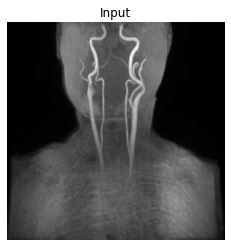

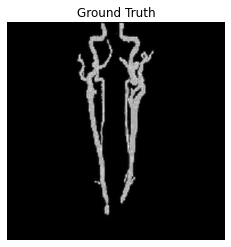

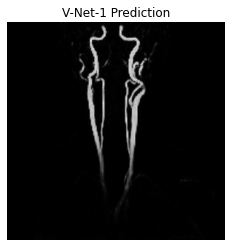

  0%|                                                    | 0/30 [00:15<?, ?it/s]


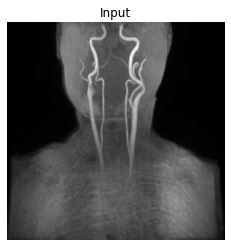

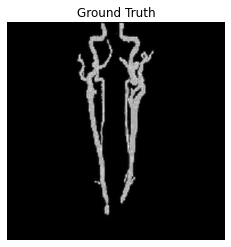

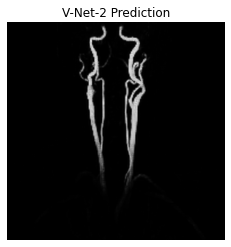

  0%|                                                    | 0/30 [00:13<?, ?it/s]


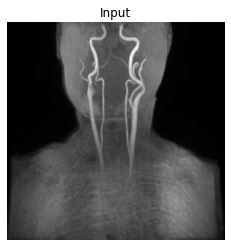

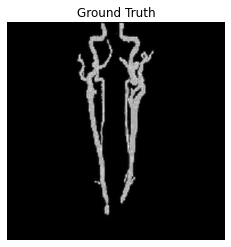

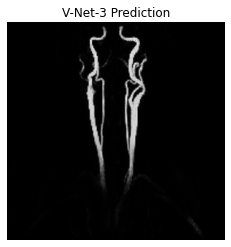

  0%|                                                    | 0/30 [00:15<?, ?it/s]


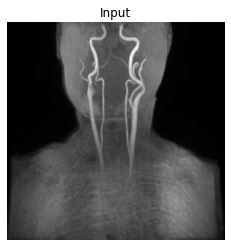

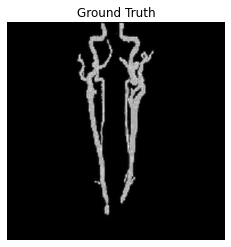

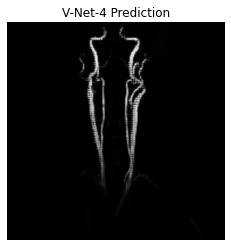

In [23]:
# Evaluation (예시 이미지)
from scipy.ndimage import rotate, zoom

batch_size = 1
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16)

for blocknum in range(1, 5):
    normalization = 'groupnorm'

    net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)))
    net.cuda()

    net.eval()

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    

    #             l1=(labels==1)
    #             l0=(labels==0)
    #             labels = torch.cat((l0,l1),1)

            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()

            outputs_seg = net(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)            
            break

    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    scale = 300 / img_size

    plt.title("Input")
    img_in = zoom(one_output_img[0], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_in, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    plt.title("Ground Truth")
    img_gt = zoom(one_output_lbl[0], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_gt, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    plt.title("V-Net-{} Prediction".format(blocknum))
    img_p = zoom(one_output_seg[1], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_p, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    # nifti_img = nib.Nifti1Image(img, affine=np.eye(4))

In [62]:
image_dir = './input_nifti/'  #'./input_nifti_300/'
label_dir = './input_nifti_seg/'  #'./seg_nifti_300/'
subjects, dataset = prepare_dataset(image_dir, label_dir)
print('Dataset size : ', len(dataset), 'subjects')

100%|████████████████████████████████████████| 30/30 [00:00<00:00, 12056.06it/s]

Dataset size :  30 subjects


In [63]:
set_seed()

split_rate = 0.8
_, _, _, d = dataset[0].shape
w, h = 300, 300
img_size = 192  # [16,32,48,64,80,96,112,128,144,160, 176,192,208,224]
sample_rate = 300 / img_size

# transformation
preprocess = tio.Compose([
#     tio.Resample(sample_rate),
#     tio.Resample(1.5),
#     tio.Crop((44,44,44,44,54,34)),
#     tio.Clamp(480,720),
    tio.ZNormalization(),
    tio.OneHot(),
])

# all data set
dataset = tio.SubjectsDataset(subjects, transform=preprocess)
print('Dataset:', len(dataset), 'subjects')

Dataset: 30 subjects


In [64]:
dataset[0]

Subject(Keys: ('img', 'label'); images: 2)

In [65]:
sample_img = dataset[0]['label']
type(sample_img)

torchio.data.image.LabelMap

In [66]:
sample_img.shape

(2, 512, 512, 232)

In [67]:
_input = dataset[0]['img']
_label = dataset[0]['label']

In [68]:
_input = _input.numpy()

In [69]:
_label = _label.numpy()

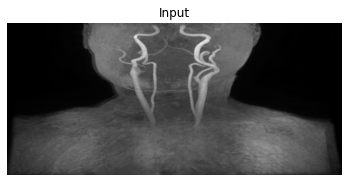

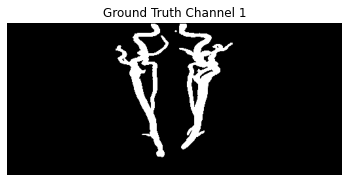

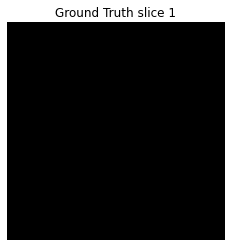

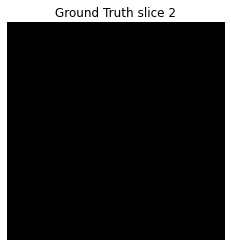

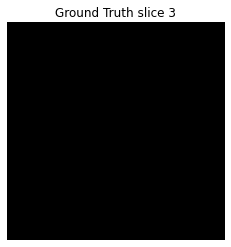

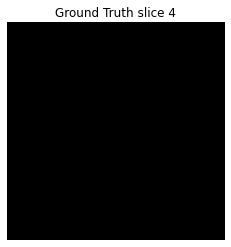

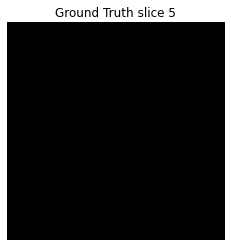

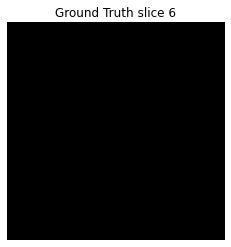

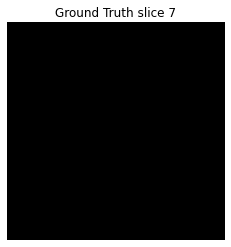

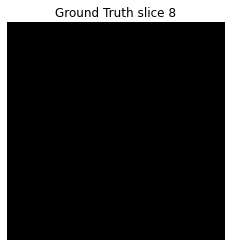

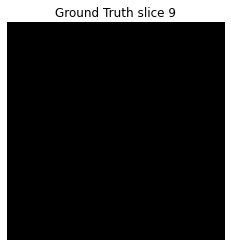

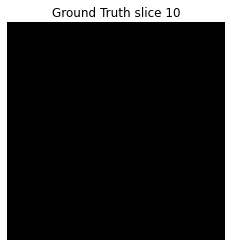

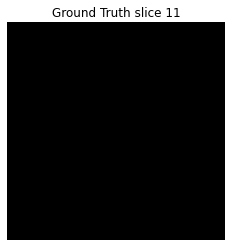

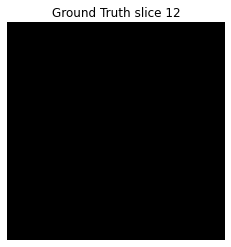

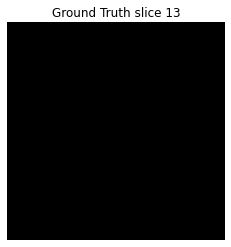

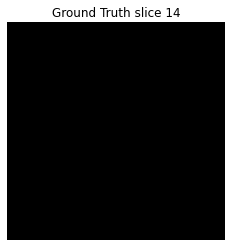

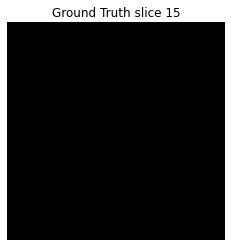

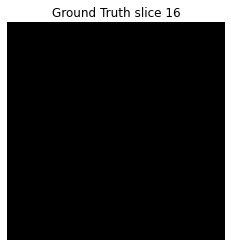

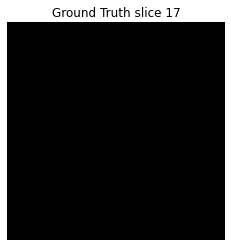

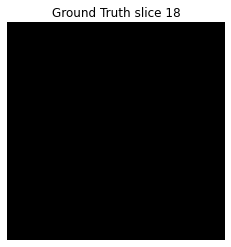

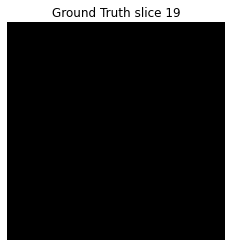

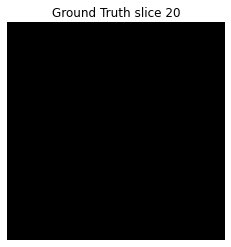

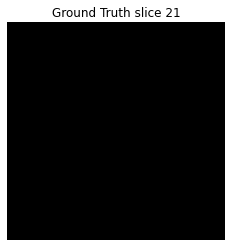

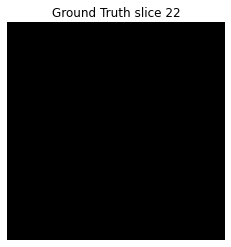

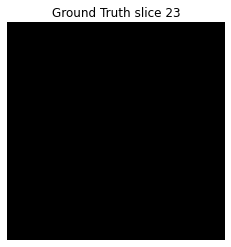

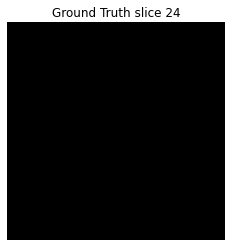

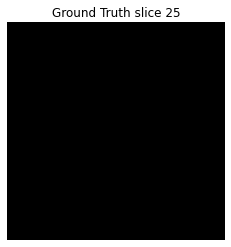

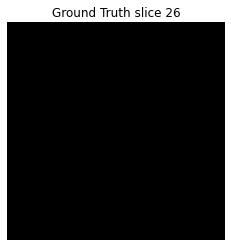

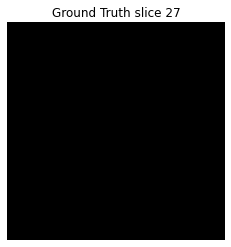

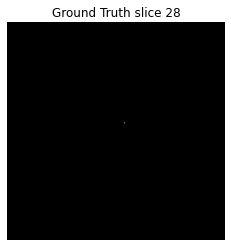

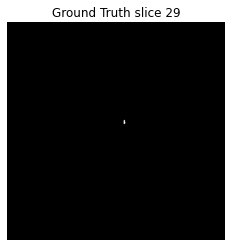

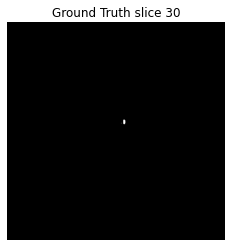

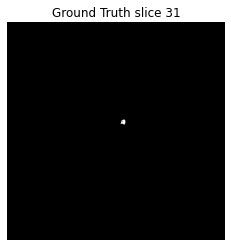

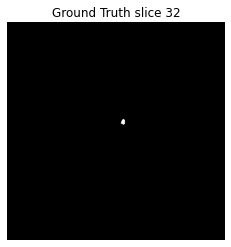

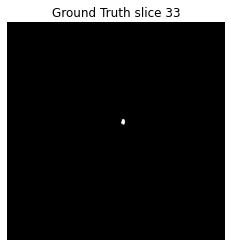

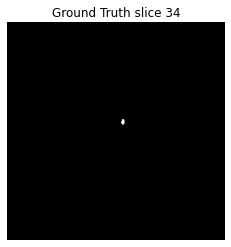

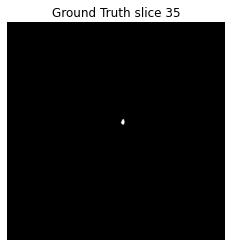

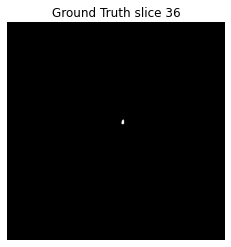

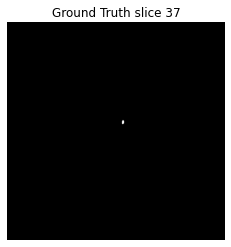

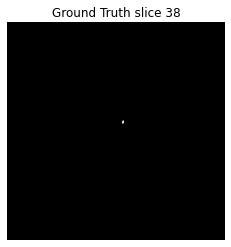

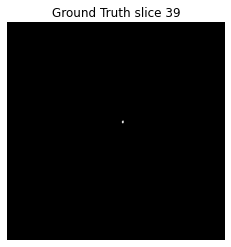

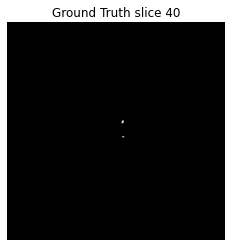

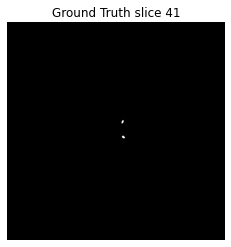

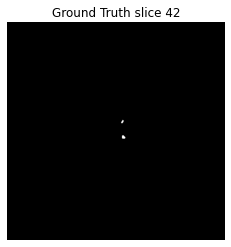

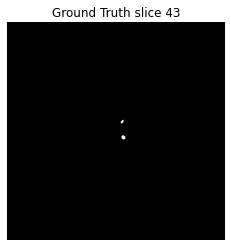

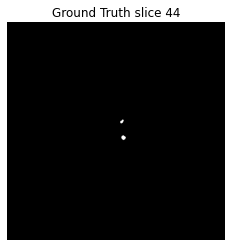

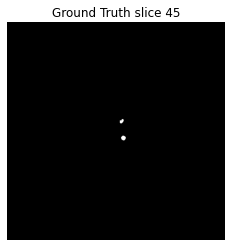

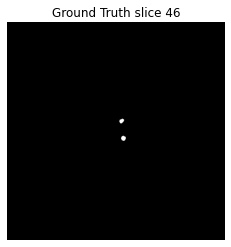

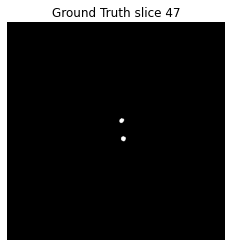

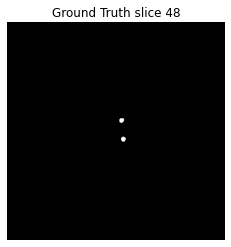

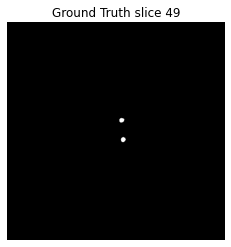

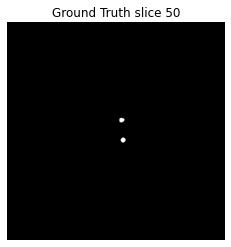

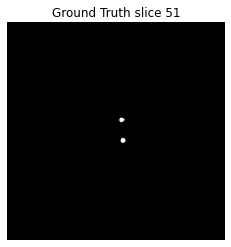

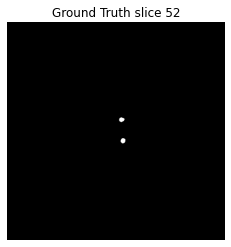

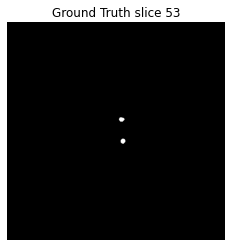

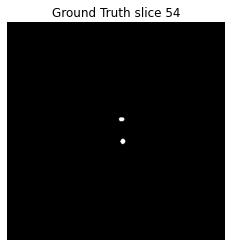

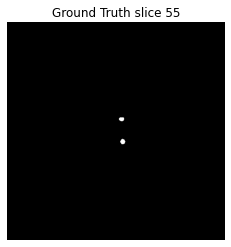

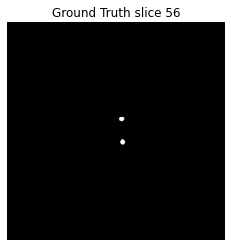

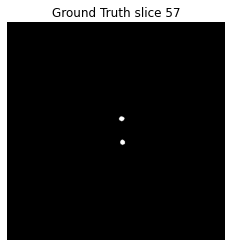

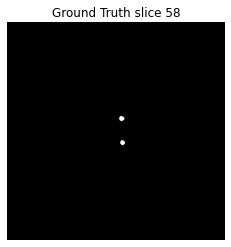

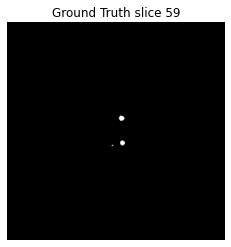

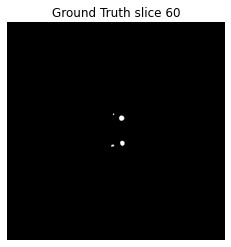

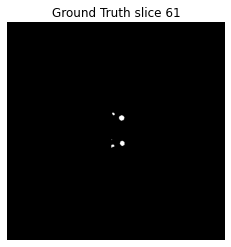

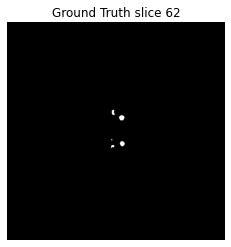

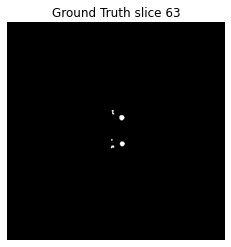

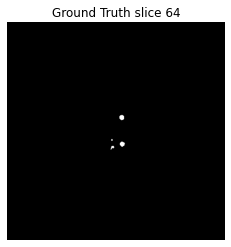

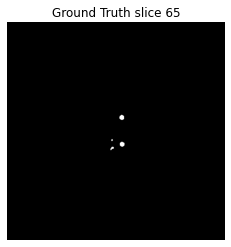

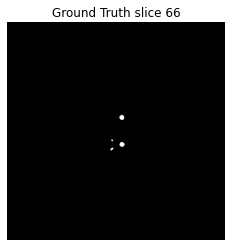

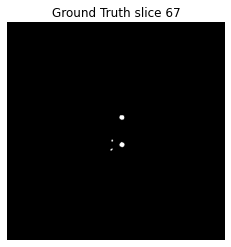

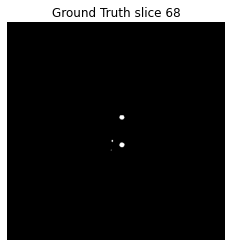

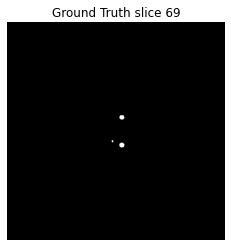

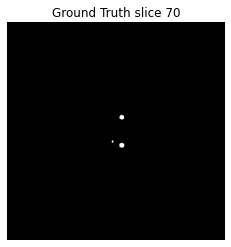

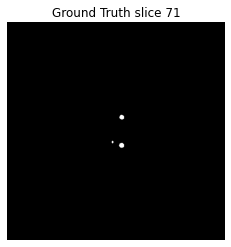

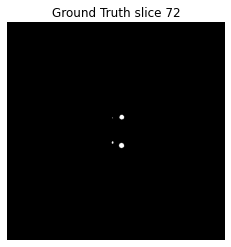

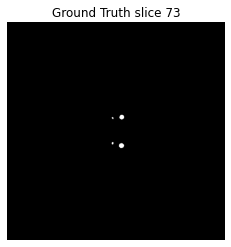

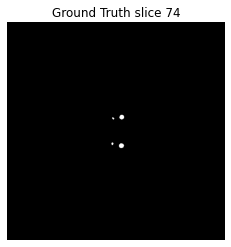

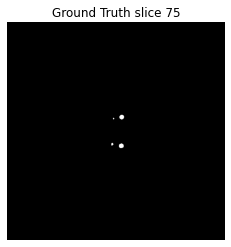

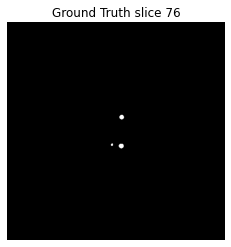

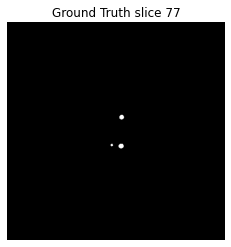

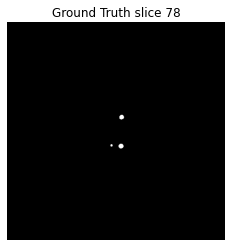

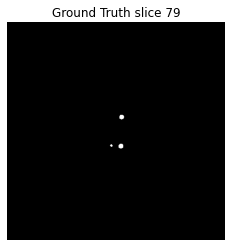

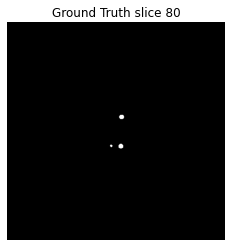

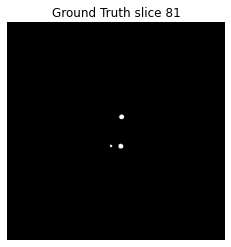

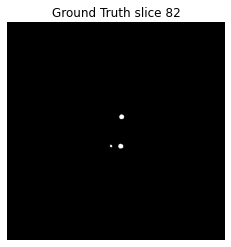

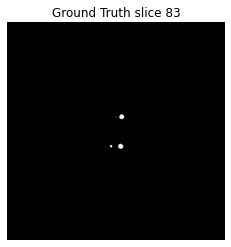

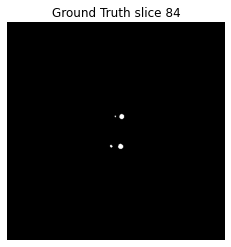

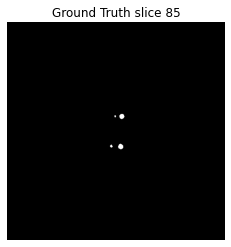

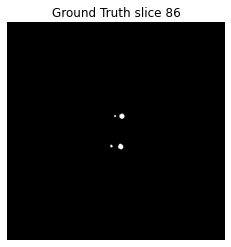

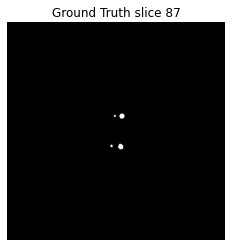

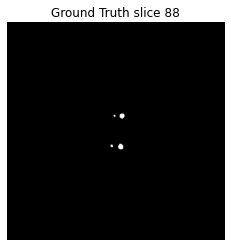

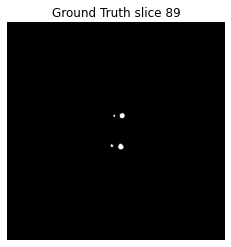

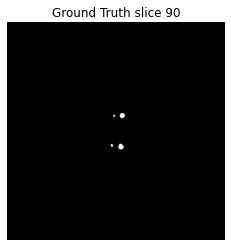

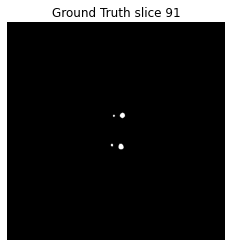

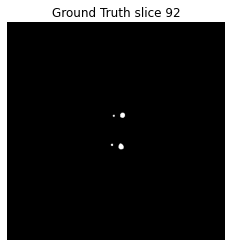

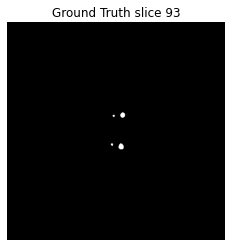

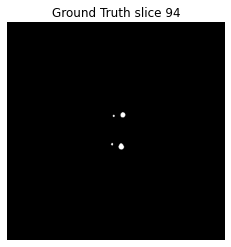

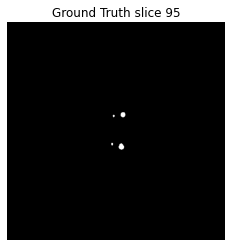

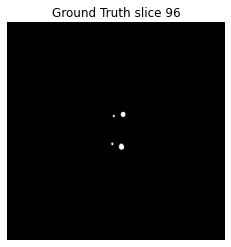

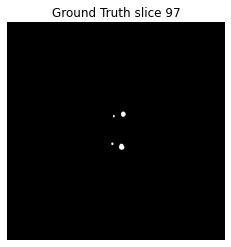

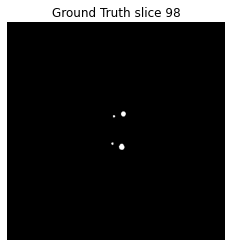

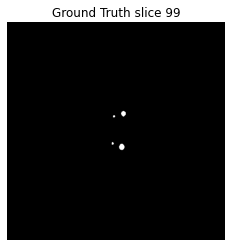

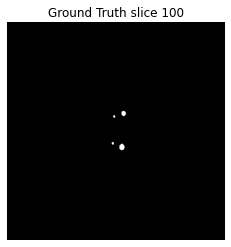

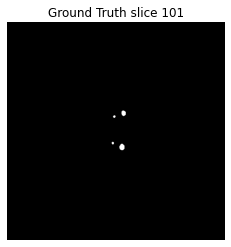

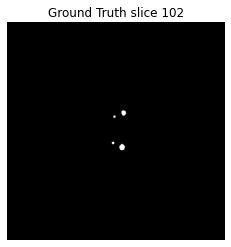

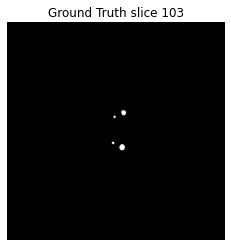

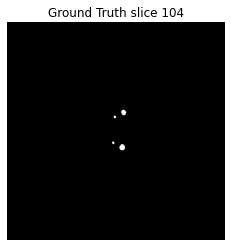

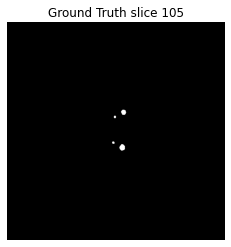

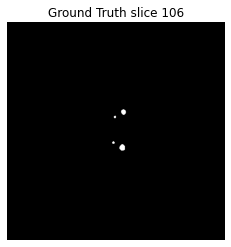

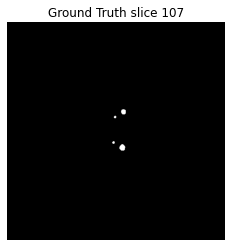

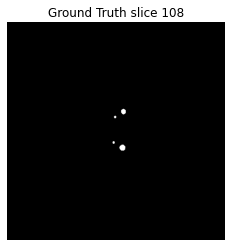

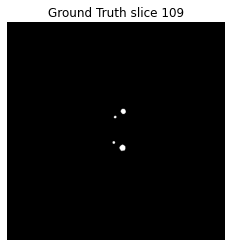

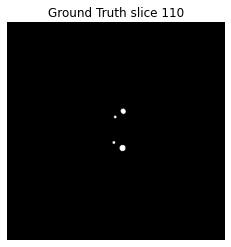

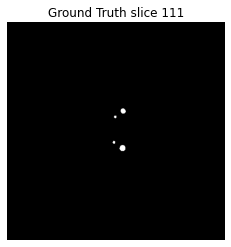

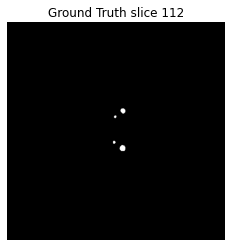

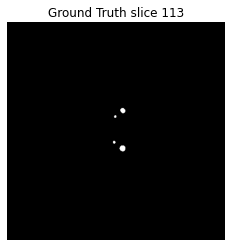

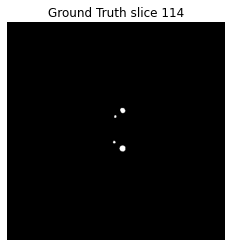

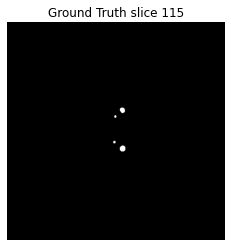

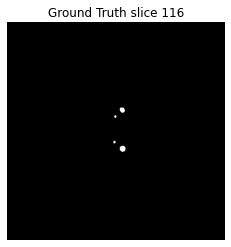

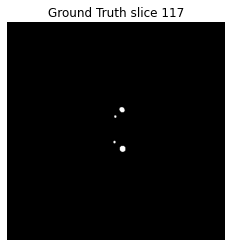

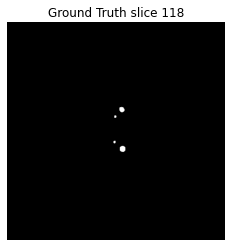

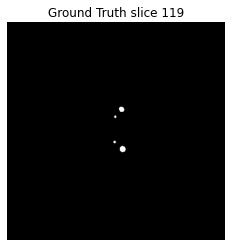

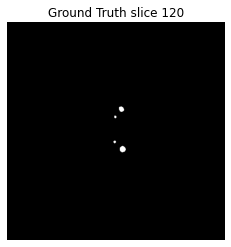

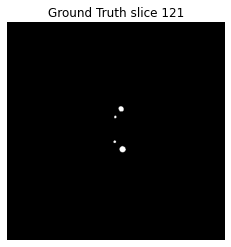

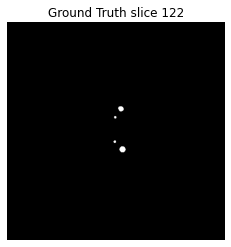

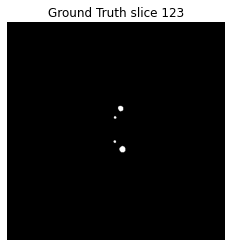

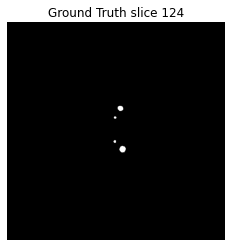

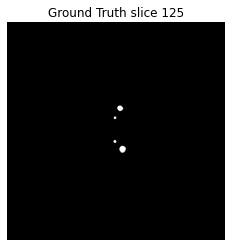

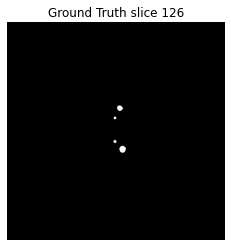

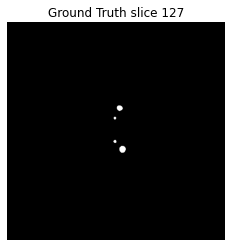

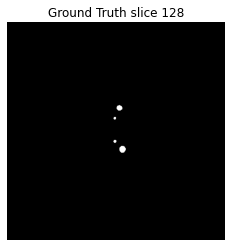

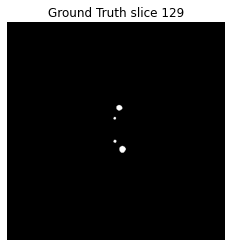

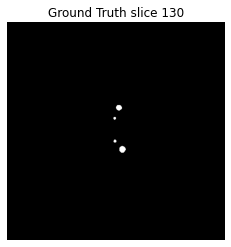

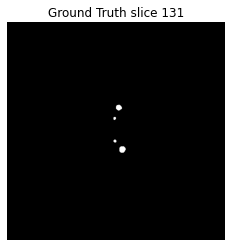

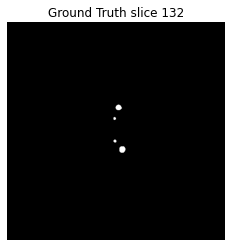

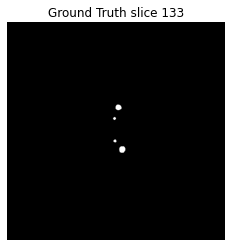

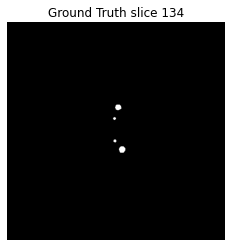

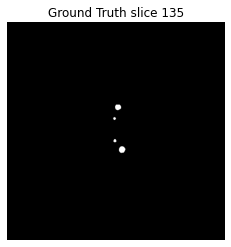

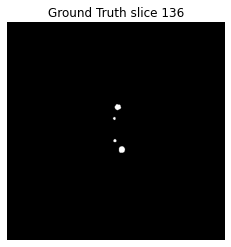

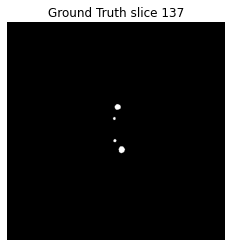

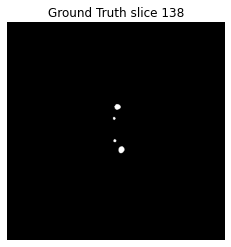

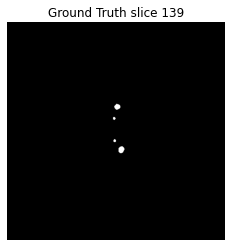

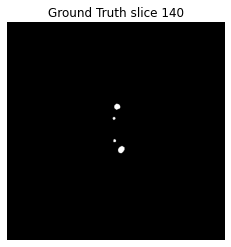

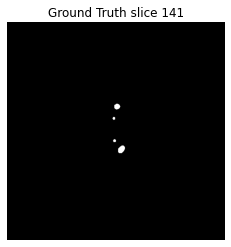

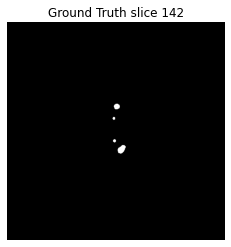

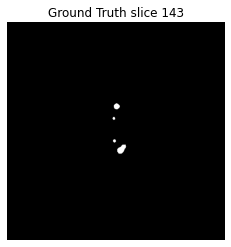

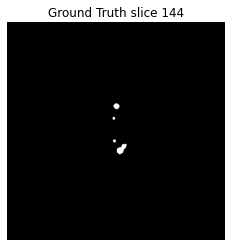

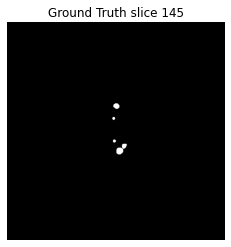

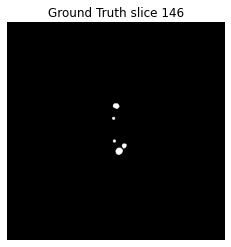

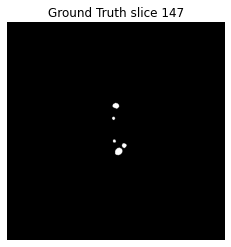

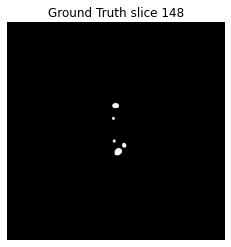

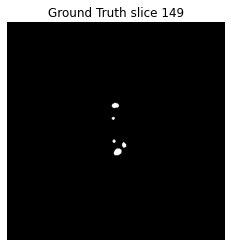

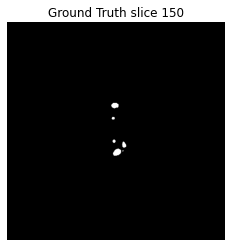

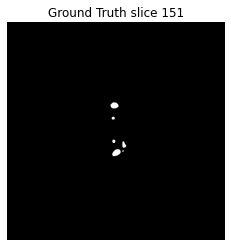

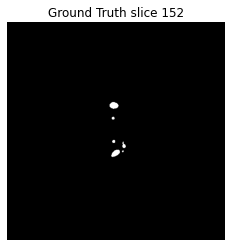

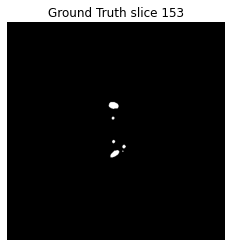

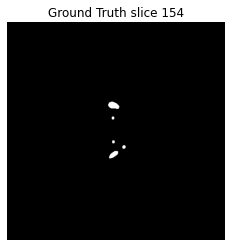

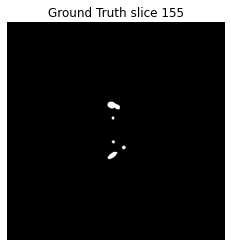

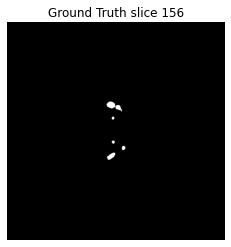

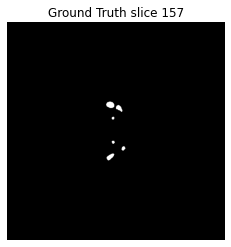

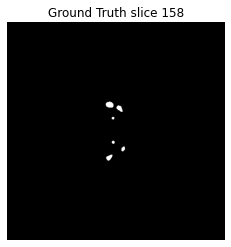

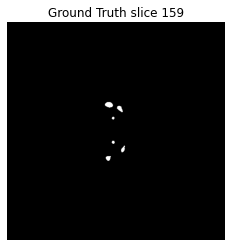

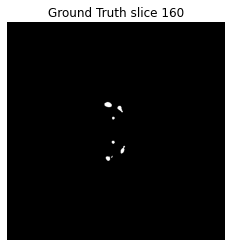

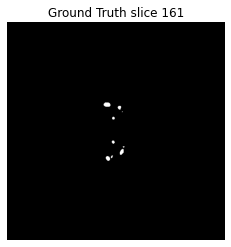

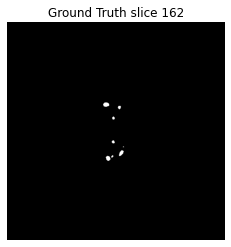

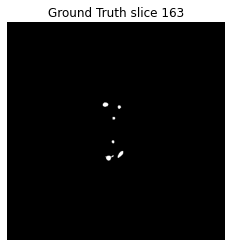

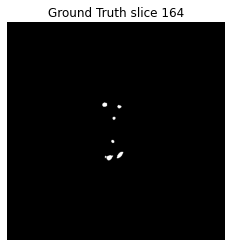

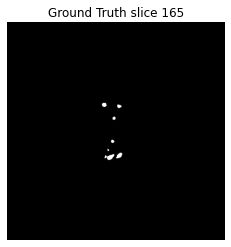

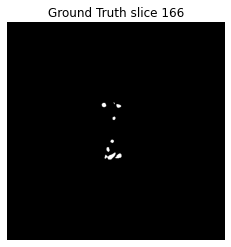

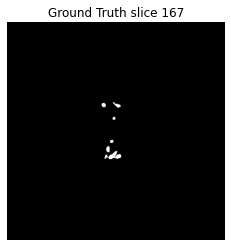

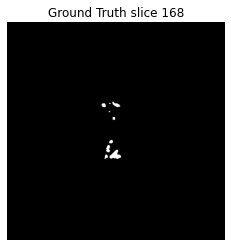

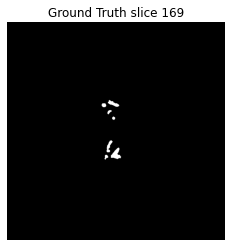

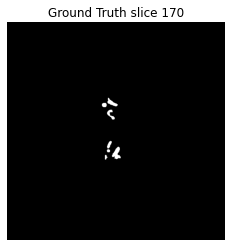

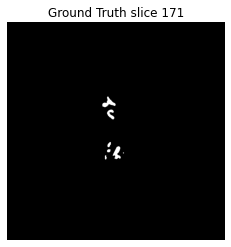

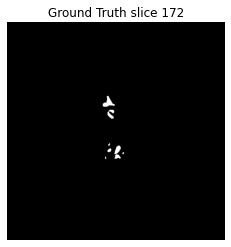

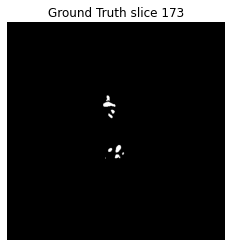

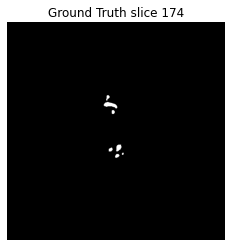

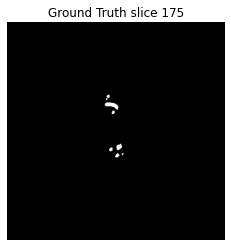

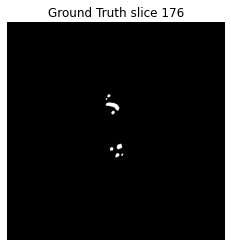

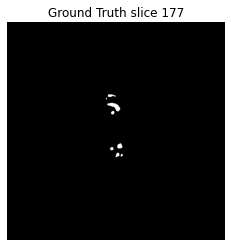

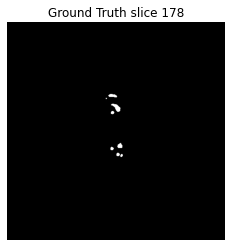

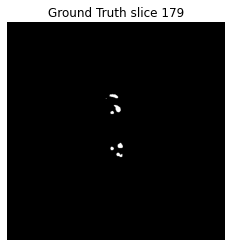

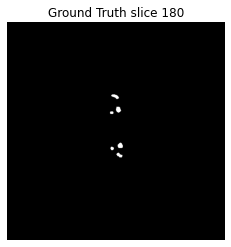

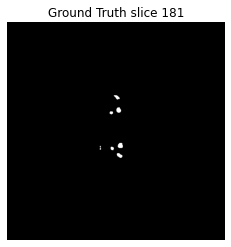

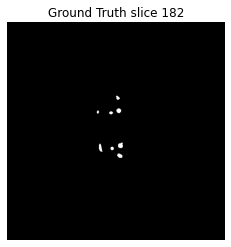

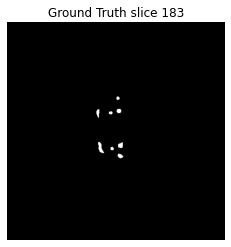

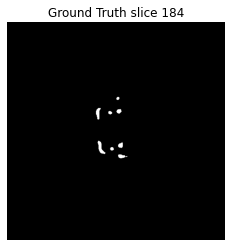

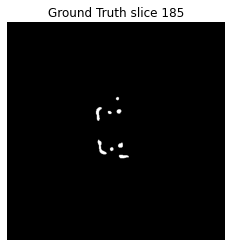

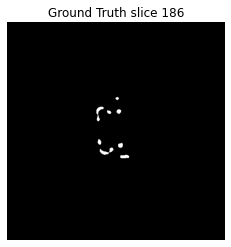

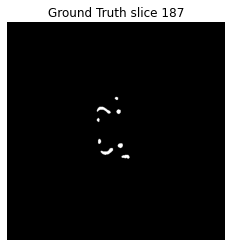

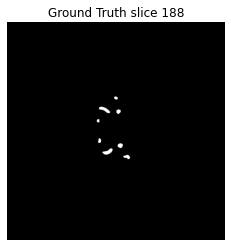

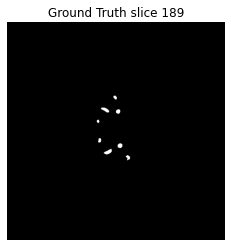

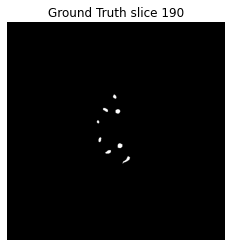

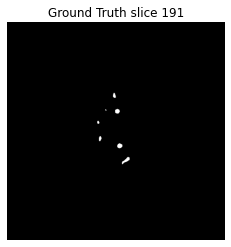

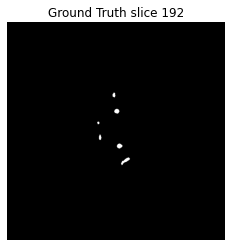

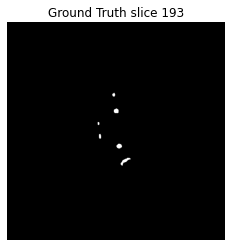

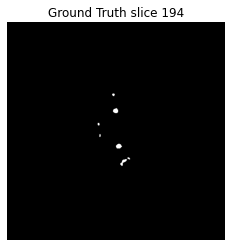

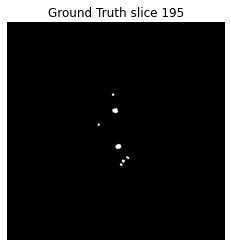

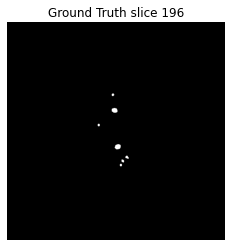

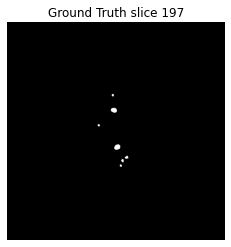

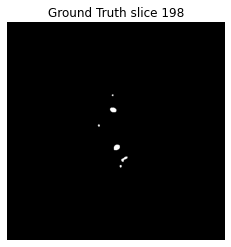

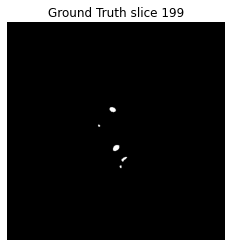

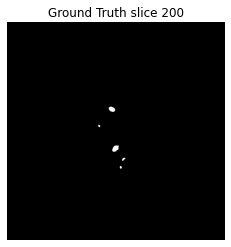

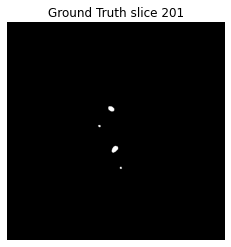

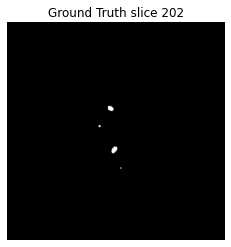

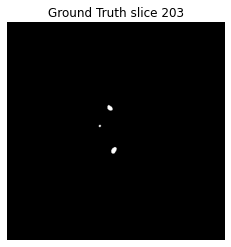

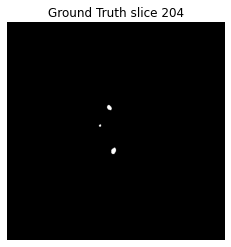

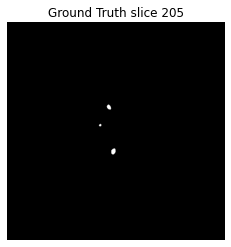

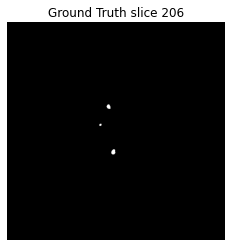

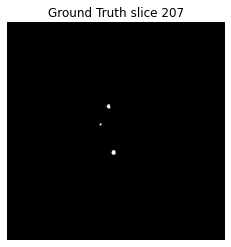

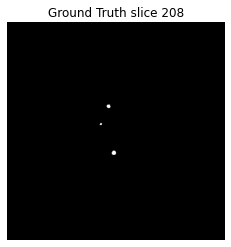

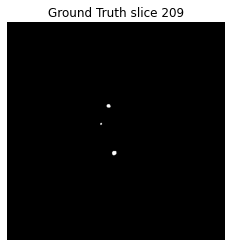

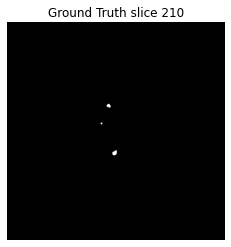

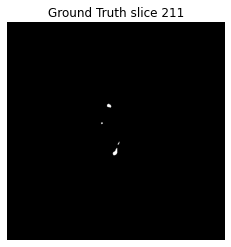

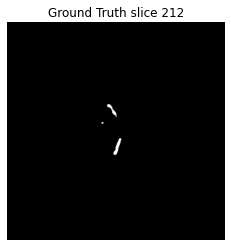

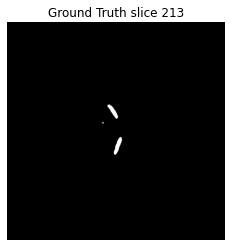

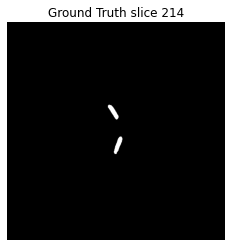

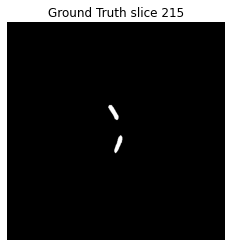

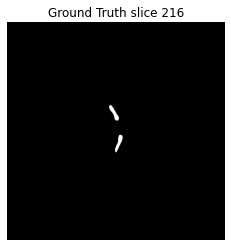

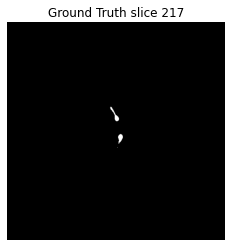

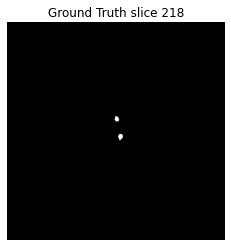

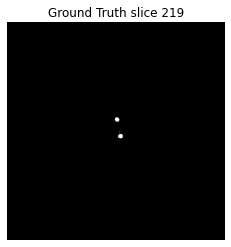

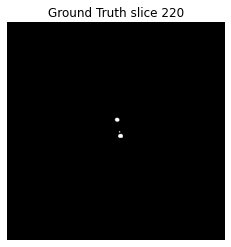

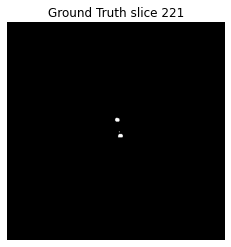

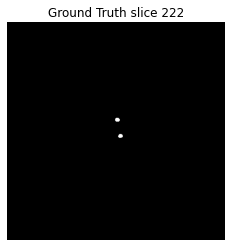

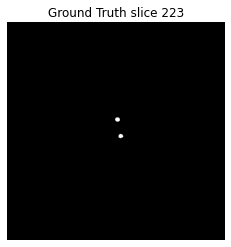

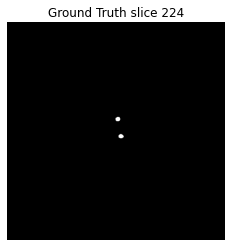

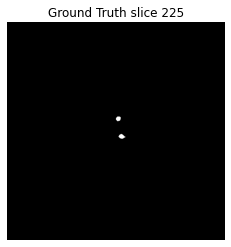

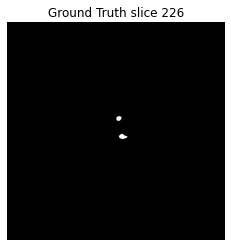

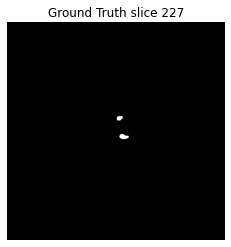

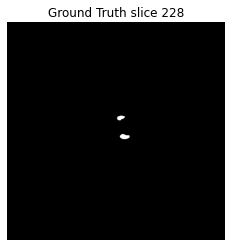

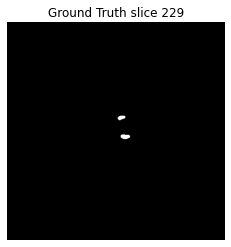

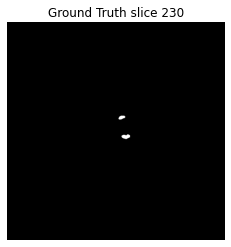

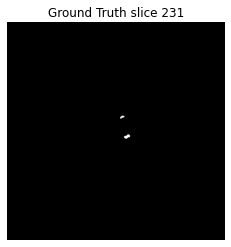

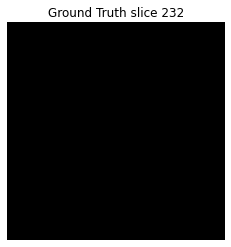

IndexError: index 232 is out of bounds for axis 2 with size 232

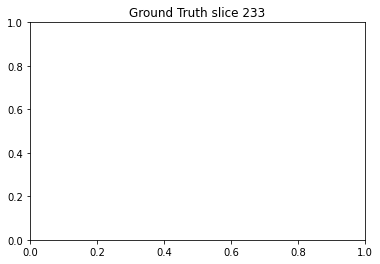

In [70]:
plt.title("Input")
plt.imshow(rotate(np.max(_input[0], axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

plt.title("Ground Truth Channel 1")
plt.imshow(rotate(np.max(_label[1], axis=1), 90), cmap='gray')
plt.axis('off')
plt.show()

for i in range(300):
    plt.title("Ground Truth slice {}".format(i+1))
    plt.imshow(_label[1][:,:,i], cmap='gray')
    plt.axis('off')
    plt.show()

  0%|                                                     | 0/8 [00:12<?, ?it/s]


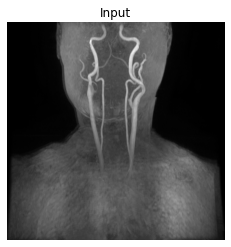

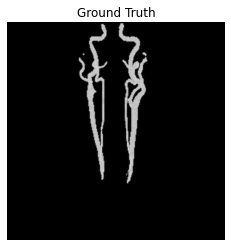

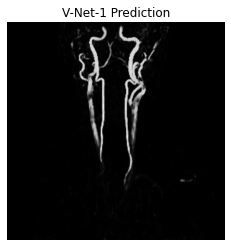

  0%|                                                     | 0/8 [00:13<?, ?it/s]


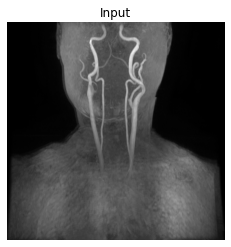

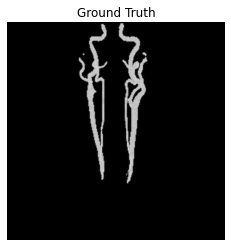

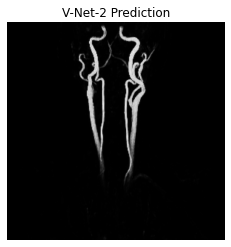

  0%|                                                     | 0/8 [00:13<?, ?it/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/torch/nn/parallel/parallel_apply.py", line 64, in _worker
    output = module(*input, **kwargs)
  File "/home/jhj/.conda/envs/a6000/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/jhj/Desktop/HJ_RESEARCH/snu_brain_disease/models/segmentation/vnet_new.py", line 160, in forward
    y = y + x.pop()  # up + x
RuntimeError: The size of tensor a (74) must match the size of tensor b (75) at non-singleton dimension 4


In [45]:
dataset2 = tio.SubjectsDataset(
    subjects, transform=tio.ZNormalization()
)
batch_size = 1
data_loader = DataLoader(dataset2, batch_size=4, num_workers=16)

for blocknum in range(1, 5):
    normalization = 'groupnorm'

    net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
    net = torch.nn.DataParallel(net, device_ids=[0, 1])
    net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)))
    net.cuda()

    net.eval()

    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader, 0)):
            inputs, labels = data['img']['data'], data['label']['data']    

    #             l1=(labels==1)
    #             l0=(labels==0)
    #             labels = torch.cat((l0,l1),1)

            if torch.cuda.is_available:
                inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

            inputs, labels = Variable(inputs), Variable(labels)

            net.eval()

            outputs_seg = net(inputs)
            outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)            
            break

    one_output_seg = outputs_seg.detach().cpu().numpy()[0]
    one_output_img = inputs.detach().cpu().numpy()[0]
    one_output_lbl = labels.detach().cpu().numpy()[0]
    scale = 300 / img_size

    plt.title("Input")
    img_in = zoom(one_output_img[0], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_in, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    plt.title("Ground Truth")
    img_gt = zoom(one_output_lbl[0], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_gt, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    plt.title("V-Net-{} Prediction".format(blocknum))
    img_p = zoom(one_output_seg[1], (scale, scale, scale))
    plt.imshow(rotate(np.max(img_p, axis=1), 90), cmap='gray')
    plt.axis('off')
    plt.show()

    # nifti_img = nib.Nifti1Image(img, affine=np.eye(4))

In [19]:
# # segmentation prediction => nifti 파일로 변환
# from scipy.ndimage import rotate, zoom

# batch_size = 1
# scale = 300 / img_size

# # weight 값 얻기 용
# data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16, shuffle=False)

# filenames = sorted(os.listdir('./seg_nifti_300/'))

# # # hyper-paramter tuning 용
# # train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)
# # valid_loader = DataLoader(valid_set, batch_size=valid_batch_size, num_workers=16)

# blocknum = 3
# normalization = 'groupnorm'

# net = VNet_New(n_channels=1, n_classes=2, n_filters=16, n_blocks=blocknum, normalization=normalization)  # num classes: 2 (background, label)
# net = torch.nn.DataParallel(net, device_ids=[0, 1])
# net.load_state_dict(torch.load('pretrained/seg_2304_vnetencoder-{}_{}_bestmodel'.format(blocknum, img_size)))
# net.cuda()

# net.eval()

# with torch.no_grad():
#     for i, data in enumerate(tqdm(data_loader, 0)):
#         inputs, labels = data['img']['data'], data['label']['data']    

# #             l1=(labels==1)
# #             l0=(labels==0)
# #             labels = torch.cat((l0,l1),1)

#         if torch.cuda.is_available:
#             inputs, labels = inputs.type(torch.cuda.FloatTensor),labels.type(torch.cuda.FloatTensor)

#         inputs, labels = Variable(inputs), Variable(labels)

#         net.eval()

#         outputs_seg = net(inputs)
#         outputs_seg = torch.nn.Softmax(dim=1)(outputs_seg)            
        
# #         print(outputs_seg.shape)
#         img_seg = outputs_seg.detach().cpu().numpy().squeeze()
#         img_seg = zoom(img_seg[1], (scale, scale, scale))
# #         plt.title("Prediction")
# #         plt.imshow(rotate(np.max(img_seg, axis=1), 90), cmap='gray')
# #         plt.axis('off')
# #         plt.show()
        
#         # save as nib
#         save_path = "seg_nifti_300_2306/" + filenames[i]
#         nifti_img = nib.Nifti1Image(img_seg, affine=np.eye(4))
#         nib.save(nifti_img, save_path)

100%|█████████████████████████████████████████| 130/130 [22:14<00:00, 10.26s/it]
